# Slides for 2018-06-29 Meeting

In [496]:
import os
import sys
from pathlib import Path

from IPython.display import display, HTML, Markdown
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.stats import fisher_exact

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import gffutils

# Project level imports
from larval_gonad.config import read_config
from larval_gonad.notebook import Nb
from larval_gonad.scRNAseq import fe_tsne, raw_data, norm_data
from larval_gonad.normalization import tpm, rpkm, zscore

In [497]:
# Setup notebook
nbconfig = Nb.setup_notebook(seurat_dir='../scrnaseq-wf/data/scrnaseq_combine_force/')

last updated: 2018-06-29 
Git hash: 39c7498a12338ed1f98522f52ca181c68e8cd0d5


In [498]:
cmapper = {nbconfig.CLUSTER_ANNOT[k]: v for k, v in zip(nbconfig.CLUSTER_ANNOT, nbconfig.colors['clusters'])}
font = {'size': 12, 'weight': 'bold'}

def add_labels(ax):
    pos = 0.04
    for clus in nbconfig.CLUSTER_ORDER:
        ax.plot(pos, 1, 'bo', markersize=5, color=cmapper[clus])
        pos += 0.084
        sns.despine(ax=ax, left=True, bottom=True)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

In [499]:
db = gffutils.FeatureDB('/data/LCDB/lcdb-references/dmel/r6-11_and_ercc/gtf/dmel_r6-11_and_ercc.gtf.db')

transcripts = db.features_of_type('transcript')

ts_lens = []
for transcript in transcripts:
    _id = transcript.id
    _gene = transcript.attributes.get('gene_id')[0]
    ts_lens.append((_gene, _id, len(transcript)))

gene_lens = pd.DataFrame(ts_lens, columns=['gene_id', 'ts_id', 'ts_length']).groupby('gene_id').ts_length.agg('max')

/home/fearjm/miniconda3/envs/larval_gonad/lib/python3.6/site-packages/gffutils/interface.py:161: UserWarning: It appears that this database has not had the ANALYZE sqlite3 command run on it. Doing so can dramatically speed up queries, and is done by default for databases created with gffutils >0.8.7.1 (this database was created with version 0.8.7.1) Consider calling the analyze() method of this object.
  "method of this object." % self.version)


## Figure 1

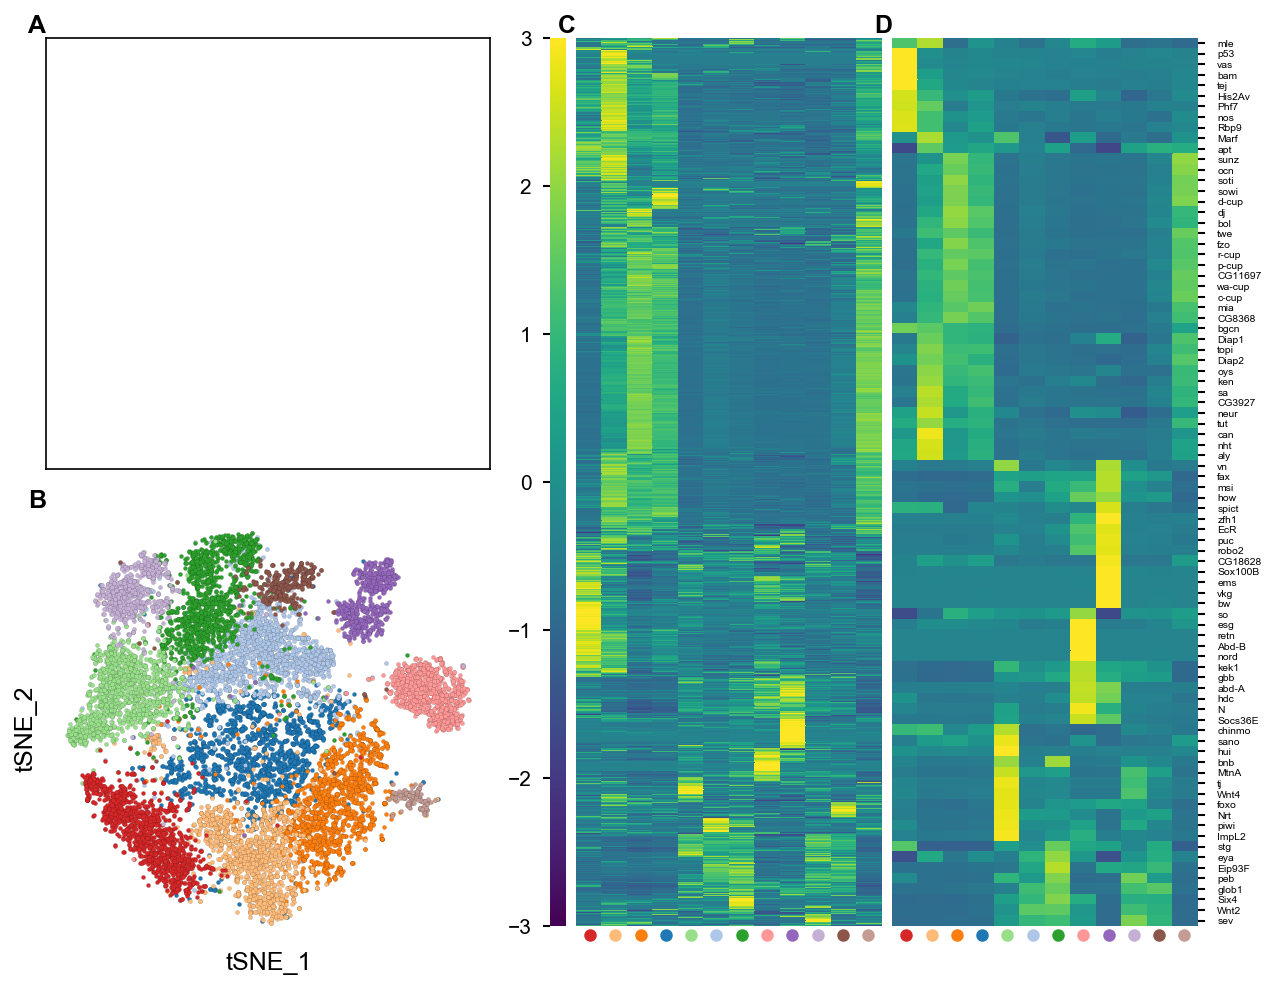

In [553]:
fig = plt.figure(figsize=(8, 8))

gs1 = plt.GridSpec(2, 1, 
                   wspace=.05, hspace=.1, 
                   left=0.03, right=0.4,
                  )

gs2 = plt.GridSpec(2, 3, 
                   wspace=0.05, hspace=0, 
                   left=0.45, right=0.99, 
                   height_ratios=[1, .02], width_ratios=[.05, 1, 1], 
                  )

axDia = plt.subplot(gs1[0, 0])
axTsne = plt.subplot(gs1[1, 0])

axAll = plt.subplot(gs2[0, 1])
axAllLabel = plt.subplot(gs2[1, 1])
axLit = plt.subplot(gs2[0, 2])
axLitLabel = plt.subplot(gs2[1, 2])
axCBar = plt.subplot(gs2[0, 0])

# Add figure labels
#plt.text(0.01, .91, 'A', transform=fig.transFigure, fontdict=font)
#plt.text(0.01, .5, 'B', transform=fig.transFigure, fontdict=font)
#plt.text(.43, .91, 'C', transform=fig.transFigure, fontdict=font)
#plt.text(.74, .91, 'D', transform=fig.transFigure, fontdict=font)

plt.text(0, 1, 'A', transform=axDia.transAxes, fontdict=font, va='bottom', ha='right')
plt.text(0, 1, 'B', transform=axTsne.transAxes, fontdict=font, va='bottom', ha='right')
plt.text(0, 1, 'C', transform=axAll.transAxes, fontdict=font, va='bottom', ha='right')
plt.text(0, 1, 'D', transform=axLit.transAxes, fontdict=font, va='bottom', ha='right')

# Add color labels to heatmaps
add_labels(axAllLabel)
add_labels(axLitLabel)

# Diagram
axDia.xaxis.set_visible(False)
axDia.yaxis.set_visible(False)

# TSNE
fe_tsne(seurat_dir=nbconfig.seurat_dir, ax=axTsne, s=4)
axTsne.legend_.remove()
sns.despine(ax=axTsne, left=True, bottom=True)

# Heatmap All Genes
_tpm = pd.read_parquet('../scrnaseq-wf/data/tpm.parquet')
_zscore = zscore(_tpm[nbconfig.CLUSTER_ORDER])

link = linkage(_zscore.values, 'average')
tree = dendrogram(link, no_plot=True)
leaves = tree['leaves']

sns.heatmap(_zscore.iloc[leaves], cmap='viridis', yticklabels=False, xticklabels=False, cbar_ax=axCBar, vmin=-3, vmax=3, ax=axAll)
axCBar.yaxis.tick_left()

# Output zscores for Erika
for_erika = _zscore.iloc[leaves].join(pd.Series(nbconfig.fbgn2symbol, name='gene_symbol'))
for_erika.index.name = 'FBgn'
for_erika.set_index('gene_symbol', append=True).to_csv('../output/2018-06-29_zscores_for_erika.tsv', sep='\t')

# Heatmap Literature Genes
lit_genes = [nbconfig.symbol2fbgn[x] for x in read_config('../science_submission/config.yaml')['lit_genes']]
_zlit = _zscore[_zscore.index.isin(lit_genes)]
_zlit.index = _zlit.index.map(nbconfig.fbgn2symbol)

link = linkage(_zlit.values, 'average')
tree = dendrogram(link, no_plot=True)
leaves = tree['leaves']

axLit.yaxis.set_label_position('right')
sns.heatmap(_zlit.iloc[leaves], cmap='viridis', yticklabels=True, xticklabels=False, cbar=False, vmin=-3, vmax=3, ax=axLit)
axLit.yaxis.tick_right()
plt.setp(axLit.get_yticklabels(), rotation=0, fontsize=5);

fig.savefig('../output/2018-06-29_figs_for_meeting_fig1.png', dpi=300, bbox_inches='tight')

## Figure 2

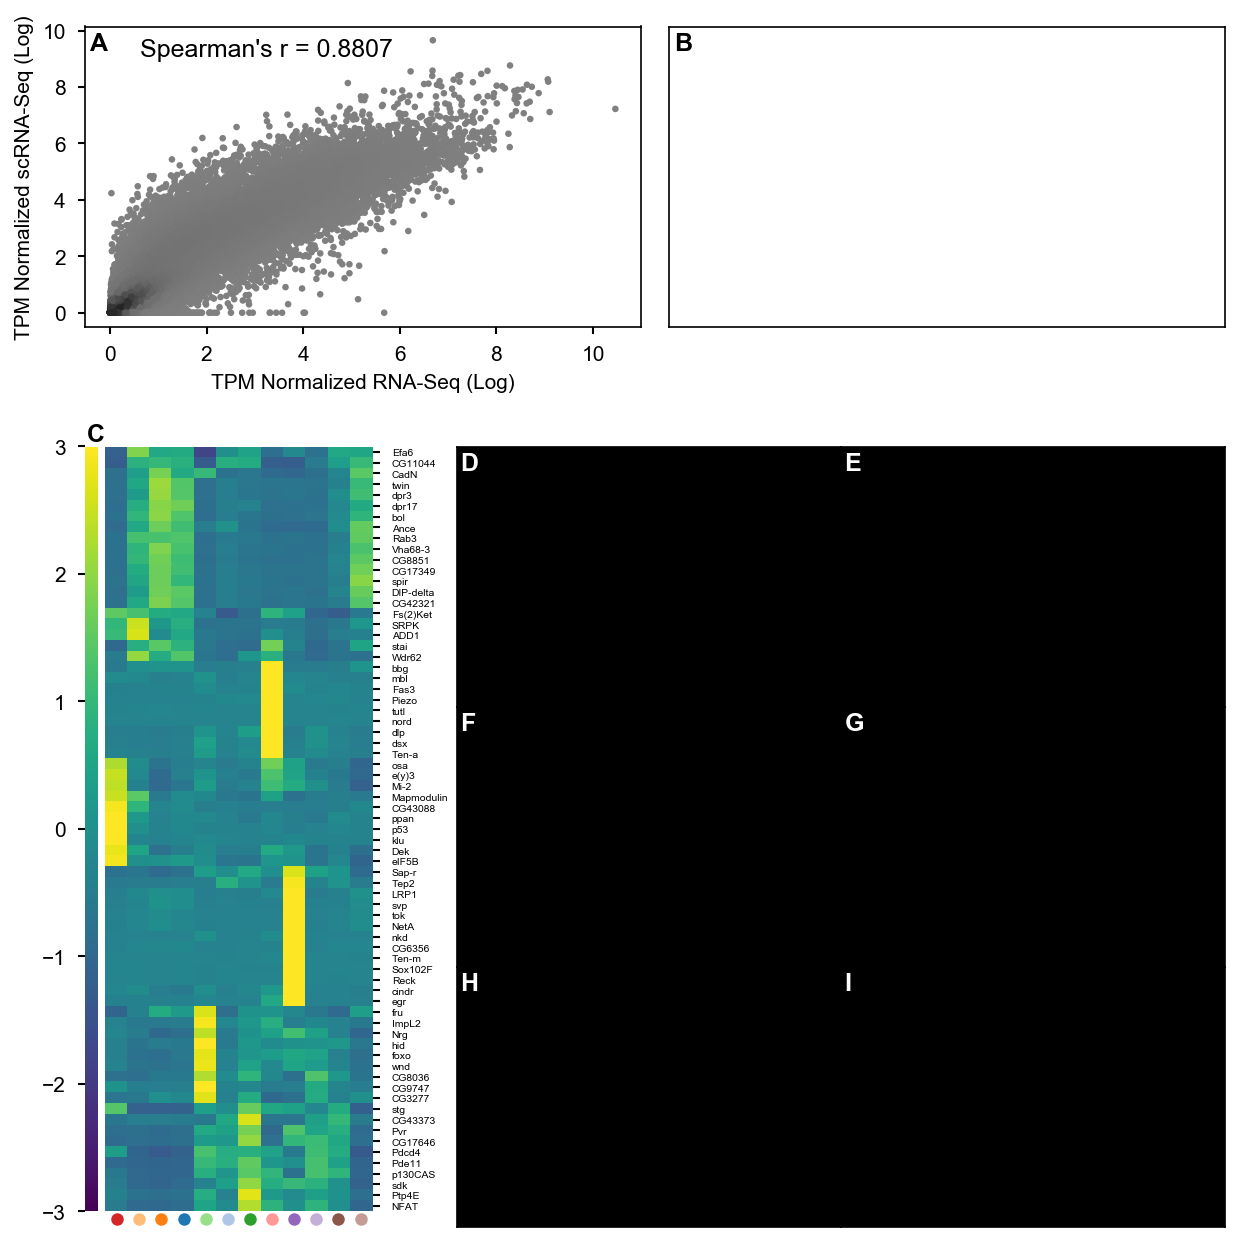

In [548]:
fig = plt.figure(figsize=(8, 8))

gs1 = plt.GridSpec(1, 2, 
                   wspace=0.05, hspace=0, 
                   left=0.04, right=.99,
                   bottom=0.75, top=1, 
                  )

axBulk = plt.subplot(gs1[0, 0])
axBulk2 = plt.subplot(gs1[0, 1])

gs2 = plt.GridSpec(2, 2, 
                   wspace=0.05, hspace=0, 
                   left=0.04, right=.28, 
                   bottom=0, top=.65, 
                   height_ratios=[1, .02], width_ratios=[0.05, 1], 
                  )

gs3 = plt.GridSpec(3, 2, 
                   wspace=0, hspace=0, 
                   left=.35, right=.99, 
                   bottom=0, top=.65, 
                  )

axPtrap = plt.subplot(gs2[0, 1])
axPtrapLabel = plt.subplot(gs2[1, 1])
axCBar = plt.subplot(gs2[0, 0])

ax1 = plt.subplot(gs3[0, 0])
ax2 = plt.subplot(gs3[0, 1])
ax3 = plt.subplot(gs3[1, 0])
ax4 = plt.subplot(gs3[1, 1])
ax5 = plt.subplot(gs3[2, 0])
ax6 = plt.subplot(gs3[2, 1])

plt.text(0.01, .98, 'A', transform=axBulk.transAxes, fontdict=font, va='top', ha='left')
plt.text(0.01, .98, 'B', transform=axBulk2.transAxes, fontdict=font, va='top', ha='left')
plt.text(0, 1, 'C', transform=axPtrap.transAxes, fontdict=font, va='bottom', ha='right')
plt.text(0.01, .98, 'D', transform=ax1.transAxes, fontdict=font, va='top', ha='left', color='w')
plt.text(0.01, .98, 'E', transform=ax2.transAxes, fontdict=font, va='top', ha='left', color='w')
plt.text(0.01, .98, 'F', transform=ax3.transAxes, fontdict=font, va='top', ha='left', color='w')
plt.text(0.01, .98, 'G', transform=ax4.transAxes, fontdict=font, va='top', ha='left', color='w')
plt.text(0.01, .98, 'H', transform=ax5.transAxes, fontdict=font, va='top', ha='left', color='w')
plt.text(0.01, .98, 'I', transform=ax6.transAxes, fontdict=font, va='top', ha='left', color='w')


for ax in [axBulk2, ax1, ax2, ax3, ax4, ax5, ax6]:
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    
add_labels(axPtrapLabel)

ax1.set_facecolor('black')
ax2.set_facecolor('black')
ax3.set_facecolor('black')
ax4.set_facecolor('black')
ax5.set_facecolor('black')
ax6.set_facecolor('black')

# Import bulk data
bulk = pd.read_parquet('../bulk-rnaseq-wf/data/aggregation/gene_level_counts.parquet')
bulk = bulk.loc[:, bulk.columns.str.contains('TDT')].sum(axis=1)

# Re-index based on bulk
gene_lens = gene_lens.reindex(bulk.index)

# tpm normalize bulk
bulk_tpm = tpm(bulk, gene_lens).dropna()
bulk_tpm = bulk_tpm[~bulk_tpm.index.str.startswith('ERCC')]
bulk_tpm.name = 'bulk'

# tpm normalize single cell
sc_raw = pd.read_parquet('../scrnaseq-wf/data/raw_agg.parquet').sum(axis=1)
sc_gene_lens = gene_lens.reindex(sc_raw.index)
sc_tpm = tpm(sc_raw, sc_gene_lens).dropna()
sc_tpm.name = 'singleCell'

# munge them and plot
data = pd.concat([sc_tpm, bulk_tpm], join='inner', axis=1)

_corr = np.log1p(data).corr().iloc[0, 1]
dataLog = np.log1p(data)
x = dataLog.iloc[:, 0].values
y = dataLog.iloc[:, 1].values
xy = np.vstack([x, y])
kde = gaussian_kde(xy)(xy)

axBulk.scatter(x, y, c=kde, edgecolor='', cmap=sns.dark_palette('grey', reverse=True, as_cmap=True), s=10)
plt.text(0.1, .9, f'Spearman\'s r = {_corr:0.4f}', transform=axBulk.transAxes, fontsize=font['size']);
axBulk.set_xlabel('TPM Normalized RNA-Seq (Log)', fontdict={'size': 10})
axBulk.set_ylabel('TPM Normalized scRNA-Seq (Log)', fontdict={'size': 10})
plt.setp(axBulk.get_xticklabels(), fontsize=10)


# Heatmap PTrap Genes
ptrap_genes = [nbconfig.symbol2fbgn[x] for x in read_config('../science_submission/config.yaml')['protein_trap_genes']]
_zp = _zscore[_zscore.index.isin(ptrap_genes)]
_zp.index = _zp.index.map(nbconfig.fbgn2symbol)

link = linkage(_zp.values, 'average')
tree = dendrogram(link, no_plot=True)
leaves = tree['leaves']

axPtrap.yaxis.set_label_position('right')
sns.heatmap(_zp.iloc[leaves], cmap='viridis', yticklabels=True, xticklabels=False, cbar_ax=axCBar, vmin=-3, vmax=3, ax=axPtrap)
axCBar.yaxis.tick_left()
axPtrap.yaxis.tick_right()
plt.setp(axPtrap.get_yticklabels(), rotation=0, fontsize=5);

fig.savefig('../output/2018-06-29_figs_for_meeting_fig2.png', dpi=300, bbox_inches='tight')

In [463]:
# Import bulk data
bulk = pd.read_parquet('../bulk-rnaseq-wf/data/aggregation/gene_level_counts.parquet')
bulk = bulk.loc[:, bulk.columns.str.contains('TDT')].sum(axis=1)

# Re-index based on bulk
gene_lens = gene_lens.reindex(bulk.index)

# tpm normalize bulk
bulk_tpm = tpm(bulk, gene_lens).dropna()
bulk_tpm = bulk_tpm[~bulk_tpm.index.str.startswith('ERCC')]
bulk_tpm.name = 'bulk'

# tpm normalize single cell
sc_raw = pd.read_parquet('../scrnaseq-wf/data/raw_agg.parquet').sum(axis=1)
sc_gene_lens = gene_lens.reindex(sc_raw.index)
sc_tpm = tpm(sc_raw, sc_gene_lens).dropna()
sc_tpm.name = 'singleCell'

# munge them and plot
data = pd.concat([sc_tpm, bulk_tpm], join='inner', axis=1)

In [502]:
from scipy.stats import gaussian_kde

In [506]:
gaussian_kde(data.values)

LinAlgError: singular matrix

In [527]:
dataLog = np.log1p(data)
x = dataLog.iloc[:, 0].values
y = dataLog.iloc[:, 1].values
xy = np.vstack([x, y])
kde = gaussian_kde(xy)(xy)

plt.scatter(x, y, c=kde, edgecolor='', cmap=sns.dark_palette('grey', reverse=True, as_cmap=True), s=10)

In [533]:
sns.color_palette('Greys')

[(0.92950403690888117, 0.92950403690888117, 0.92950403690888117),
 (0.81911572472126104, 0.81911572472126104, 0.81911572472126104),
 (0.67700115340253753, 0.67700115340253753, 0.67700115340253753),
 (0.50857362552864283, 0.50857362552864283, 0.50857362552864283),
 (0.35912341407151094, 0.35912341407151094, 0.35912341407151094),
 (0.16793540945790081, 0.16793540945790081, 0.16793540945790081)]

AttributeError: Unknown property cmap

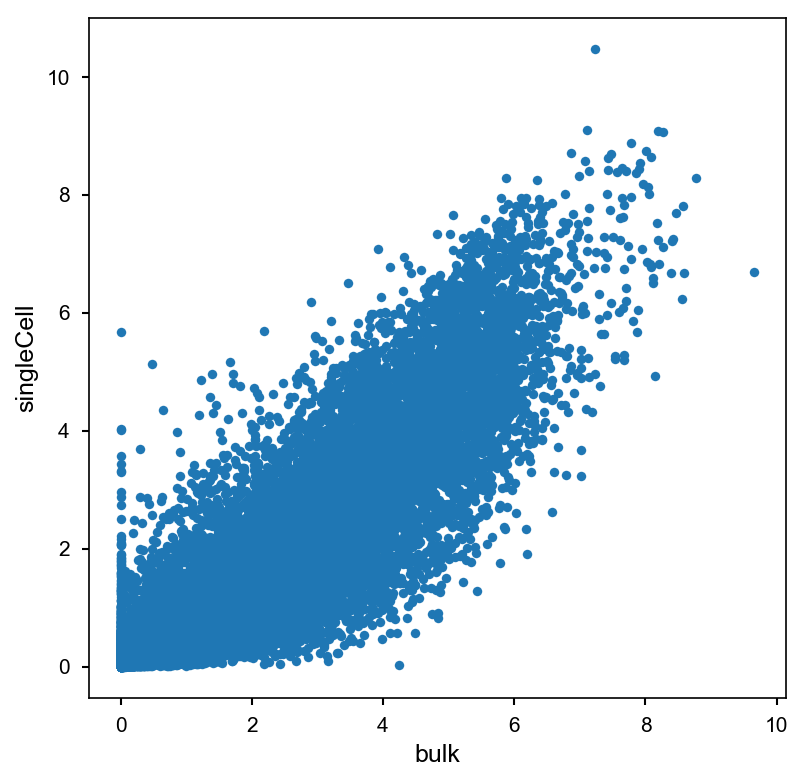

In [522]:
_corr = np.log1p(data).corr().iloc[0, 1]
ax = np.log1p(data).plot('bulk', 'singleCell', kind='scatter')
plt.text(0.1, .9, f'Spearman\'s r = {_corr:0.4f}', transform=ax.transAxes, fontsize=font['size'], cmap=kde);
ax.set_xlabel('TPM Normalized RNA-Seq (Log)')
ax.set_ylabel('TPM Normalized scRNA-Seq (Log)')

In [466]:
tpm_by_clus = pd.read_parquet('../scrnaseq-wf/data/tpm.parquet')

In [477]:
corrs = []
for g, dd in tpm_by_clus.iteritems():
    _bulk = bulk.reindex(dd.index).dropna()
    _corr, _ = spearmanr(dd, _bulk)
    corrs.append((g, _corr))

In [471]:
from scipy.stats import spearmanr

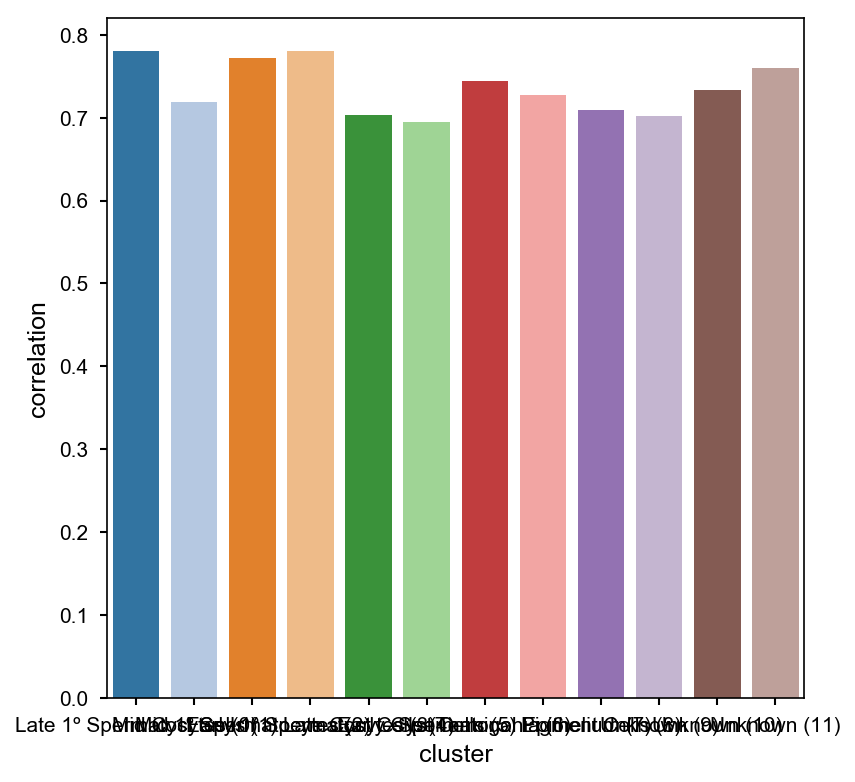

In [486]:
sns.barplot('cluster', 'correlation', data=pd.DataFrame(corrs, columns=['cluster', 'correlation']), palette=nbconfig.colors['clusters'])

In [476]:
_corr

0.78014821051149685

## Boxplots

In [190]:
raw = pd.read_parquet('../scrnaseq-wf/data/raw_agg.parquet')
snorm = pd.read_parquet('../scrnaseq-wf/data/norm_agg.parquet')
tpm = pd.read_parquet('../scrnaseq-wf/data/tpm.parquet')
rpkm = pd.read_parquet('../scrnaseq-wf/data/rpkm.parquet')

In [64]:
from larval_gonad.x_to_a import fe_chrom_boxplot, x_to_a, mann_whitney_by_arm

In [209]:
def large_panel(dat, title):
    fig, axes = plt.subplots(2, 6, figsize=plt.figaspect(1/3), sharex=True, sharey=True, gridspec_kw={'hspace': 0, 'wspace': 0})
    figZoom, axesZoom = plt.subplots(1, 4, figsize=plt.figaspect(1/3), sharex=True, sharey=True, gridspec_kw={'hspace': 0, 'wspace': 0})
    _xtoa = []
    _pvals = []
    _pvalsSample = []
    for (c, cnts), ax in zip(dat.iteritems(), axes.flatten()):
        data = cnts.to_frame().join(nbconfig.fbgn2chrom)
        data.columns = ['cnts', 'chrom']

        # Regular boxplot
        ax = fe_chrom_boxplot(c, data=data, ax=ax)
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.text(0.5, .99, c, ha='center', va='top', transform=ax.transAxes, fontsize=10)

        # Chrom to A ratios
        _df = x_to_a(c, data=data)
        _df.columns = [c]
        _xtoa.append(_df)

        # P-values for Chrom : A comparison
        _pvals.append(mann_whitney_by_arm(c, data=data))
        _pvalsSample.append(mann_whitney_by_arm(c, data=data, sample=True))

    for ax in axes[1, :]:
        for l in ax.get_xticklabels():
            l.set_rotation(75)

    fig.suptitle(title)

    targets = ['Spermatogonia (6)', 'Early 1º Spermatocytes (3)', 'Mid 1º Spermatocytes (2)', 'Late 1º Spermatocytes (0)']
    for (c, cnts), ax in zip(dat[targets].iteritems(), axesZoom.flatten()):
        data = cnts.to_frame().join(nbconfig.fbgn2chrom)
        data.columns = ['cnts', 'chrom']

        # Regular boxplot
        ax = fe_chrom_boxplot(c, data=data, ax=ax)
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.text(0.5, .99, c, ha='center', va='top', transform=ax.transAxes, fontsize=10)


    for ax in axesZoom:
        for l in ax.get_xticklabels():
            l.set_rotation(75)

    figZoom.suptitle(title)

    df_xtoa = pd.concat(_xtoa, axis=1)
    df_pvals = pd.concat(_pvals)
    df_pvalsSample = pd.concat(_pvalsSample)

    display(df_xtoa)
    display(df_pvals['chrX'].to_frame().T < 0.01)

,Late 1º Spermatocytes (0),Mid Cyst Cells (1),Mid 1º Spermatocytes (2),Early 1º Spermatocytes (3),Late Cyst Cells (4),Early Cyst Cells (5),Spermatogonia (6),Terminal Epithelium (7),Pigment Cells (8),Unknown (9),Unknown (10),Unknown (11)
chrom,,,,,,,,,,,,
chrX,0.862069,1.117647,0.763441,0.940239,1.200000,1.319149,1.439614,1.370370,1.307692,1.214286,1.166667,0.769231
chr2L,1.172414,1.000000,1.155914,1.087649,1.028571,0.936170,0.985507,0.962963,0.923077,0.928571,1.166667,1.170940
chr2R,0.965517,1.058824,0.903226,0.972112,1.085714,1.085106,1.004831,1.111111,1.115385,1.071429,1.166667,0.911681
chr3L,0.931034,0.882353,0.913978,0.924303,0.942857,0.978723,0.898551,0.925926,0.884615,0.928571,1.000000,0.923077
chr3R,1.000000,1.014706,1.021505,1.043825,1.000000,1.042553,1.062802,0.981481,1.000000,1.000000,1.000000,1.045584
chr4,0.793103,1.264706,0.650538,0.615538,2.042857,2.436170,1.468599,2.481481,2.961538,2.392857,1.583333,0.749288


cluster,Late 1º Spermatocytes (0),Mid Cyst Cells (1),Mid 1º Spermatocytes (2),Early 1º Spermatocytes (3),Late Cyst Cells (4),Early Cyst Cells (5),Spermatogonia (6),Terminal Epithelium (7),Pigment Cells (8),Unknown (9),Unknown (10),Unknown (11)
chrX,True,False,True,False,False,False,False,False,False,False,False,True


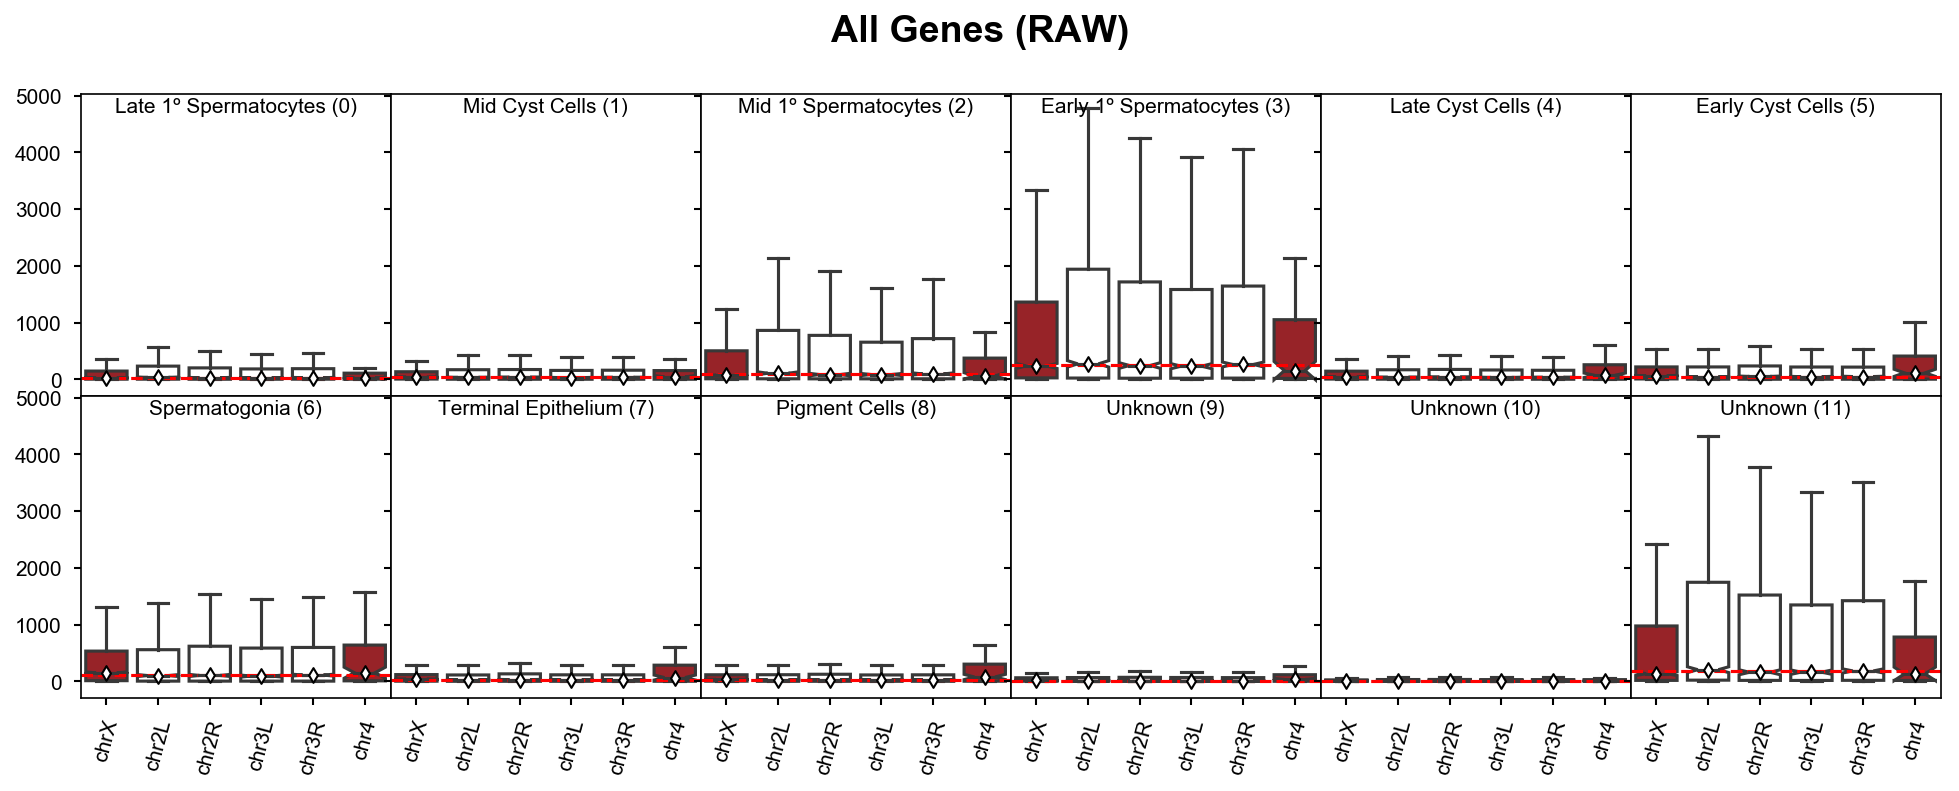

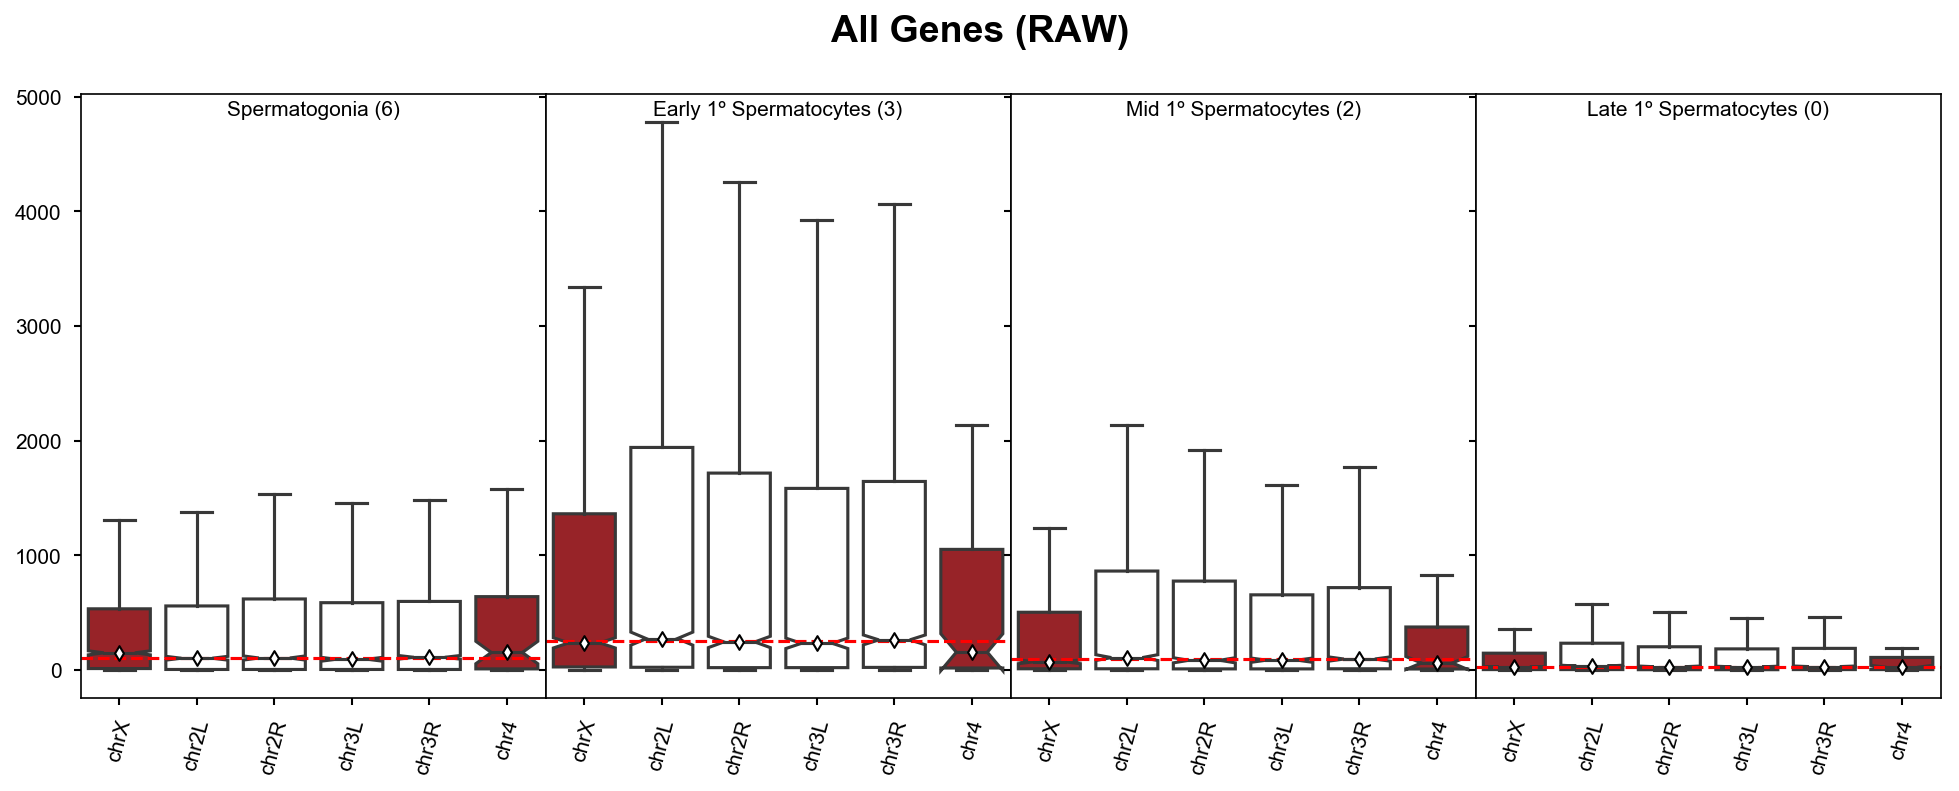

In [210]:
large_panel(raw[~(raw == 0).all(axis=1)], 'All Genes (RAW)')

,Late 1º Spermatocytes (0),Mid Cyst Cells (1),Mid 1º Spermatocytes (2),Early 1º Spermatocytes (3),Late Cyst Cells (4),Early Cyst Cells (5),Spermatogonia (6),Terminal Epithelium (7),Pigment Cells (8),Unknown (9),Unknown (10),Unknown (11)
chrom,,,,,,,,,,,,
chrX,0.862622,1.162035,0.811616,0.960711,1.168973,1.263886,1.409095,1.355783,1.305682,1.231848,1.111220,0.785242
chr2L,1.171966,0.994420,1.134482,1.077497,1.010026,0.923501,1.008577,0.974505,0.958979,1.011660,1.045591,1.171443
chr2R,0.919907,1.078545,0.911268,1.002656,1.062474,1.065056,0.967280,1.106316,1.079610,1.065633,1.065968,0.931840
chr3L,0.904649,0.891700,0.938979,0.893377,0.930978,0.936187,0.896356,0.931796,0.934722,0.954651,0.899199,0.925791
chr3R,1.013121,1.037584,1.001649,1.023237,0.999313,1.058876,1.095130,0.991949,1.024234,0.990405,0.998758,1.058238
chr4,0.842567,1.402674,0.818363,0.592302,2.122269,2.649561,1.357780,2.441758,3.032488,2.251534,1.499368,0.753319


cluster,Late 1º Spermatocytes (0),Mid Cyst Cells (1),Mid 1º Spermatocytes (2),Early 1º Spermatocytes (3),Late Cyst Cells (4),Early Cyst Cells (5),Spermatogonia (6),Terminal Epithelium (7),Pigment Cells (8),Unknown (9),Unknown (10),Unknown (11)
chrX,False,False,True,False,False,False,False,False,False,False,False,True


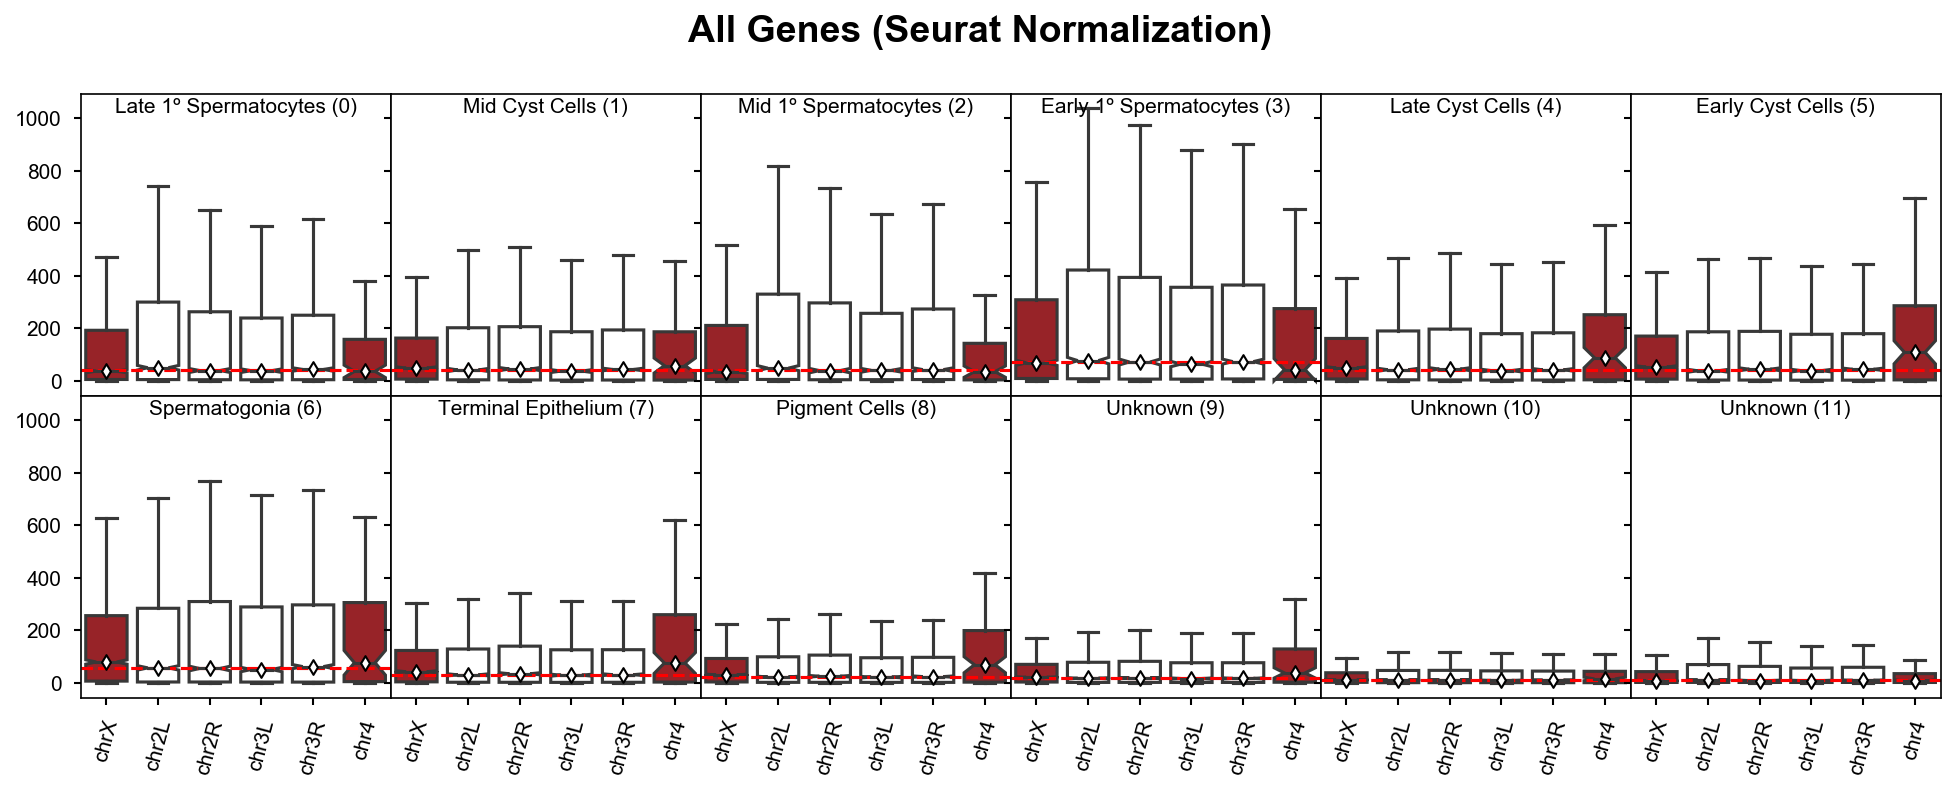

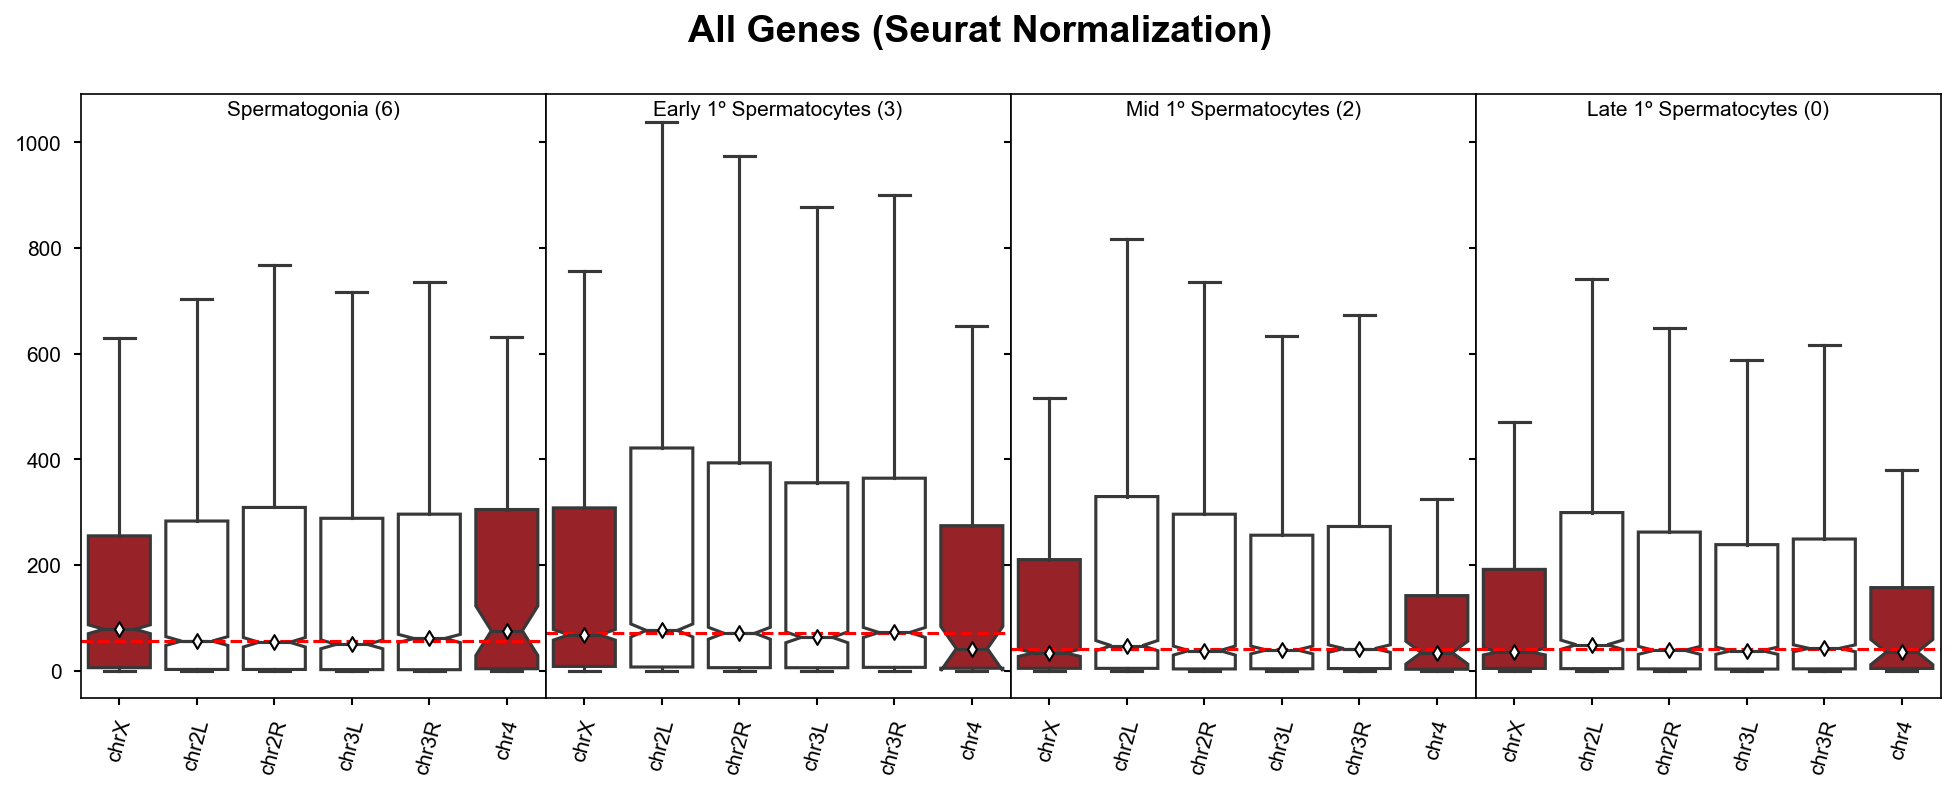

In [211]:
large_panel(snorm[~(snorm == 0).all(axis=1)], 'All Genes (Seurat Normalization)')

,Late 1º Spermatocytes (0),Mid Cyst Cells (1),Mid 1º Spermatocytes (2),Early 1º Spermatocytes (3),Late Cyst Cells (4),Early Cyst Cells (5),Spermatogonia (6),Terminal Epithelium (7),Pigment Cells (8),Unknown (9),Unknown (10),Unknown (11)
chrom,,,,,,,,,,,,
chrX,0.697333,1.080704,0.607416,0.801839,1.110685,1.295563,1.256676,1.342351,1.199546,1.214855,1.020901,0.616298
chr2L,1.176436,1.070610,1.098743,1.073251,1.000772,0.975412,0.967204,0.966211,0.968450,1.022059,1.058136,1.086068
chr2R,0.886362,1.012039,0.900133,0.890292,1.038901,1.050120,1.000933,1.077302,1.092774,1.031917,0.946397,0.902171
chr3L,0.952863,0.962969,0.969385,0.955435,0.986541,1.001871,0.974945,0.962857,0.953759,0.970348,1.005733,0.978348
chr3R,1.010393,0.969245,1.017971,1.026007,0.961435,0.981261,1.043036,1.015154,0.999751,0.960693,1.009620,0.995084
chr4,0.526833,0.544281,0.605468,0.591403,0.923386,1.162872,0.722240,1.981681,2.025602,1.160143,0.749340,0.578573


cluster,Late 1º Spermatocytes (0),Mid Cyst Cells (1),Mid 1º Spermatocytes (2),Early 1º Spermatocytes (3),Late Cyst Cells (4),Early Cyst Cells (5),Spermatogonia (6),Terminal Epithelium (7),Pigment Cells (8),Unknown (9),Unknown (10),Unknown (11)
chrX,True,False,True,True,False,False,False,False,False,False,False,True


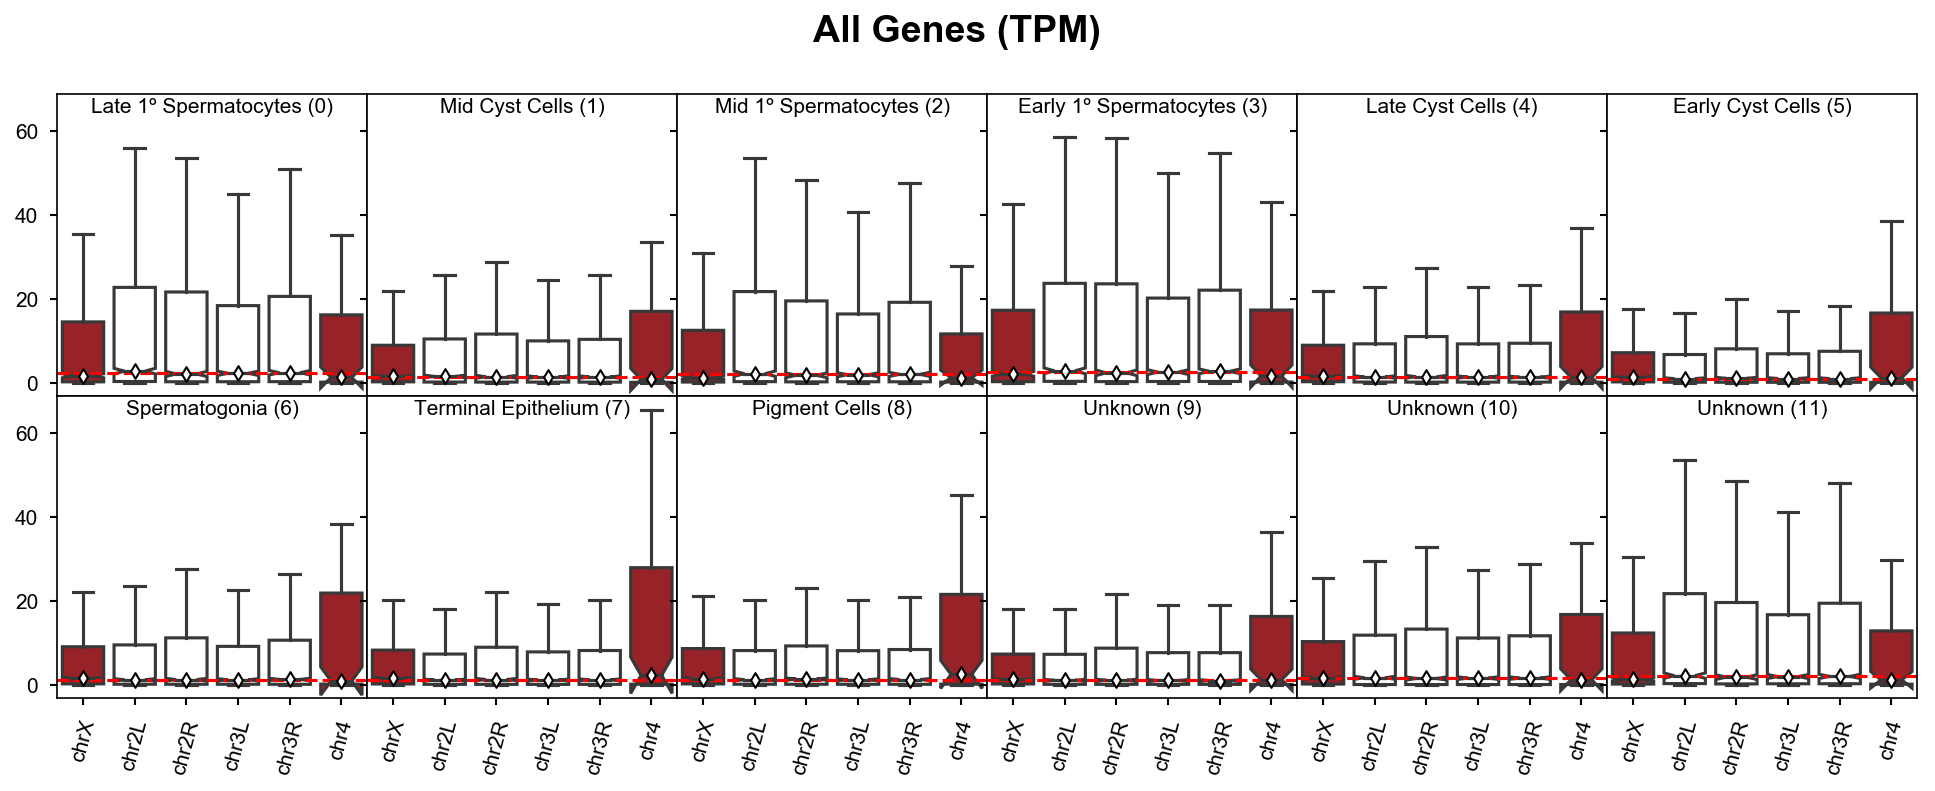

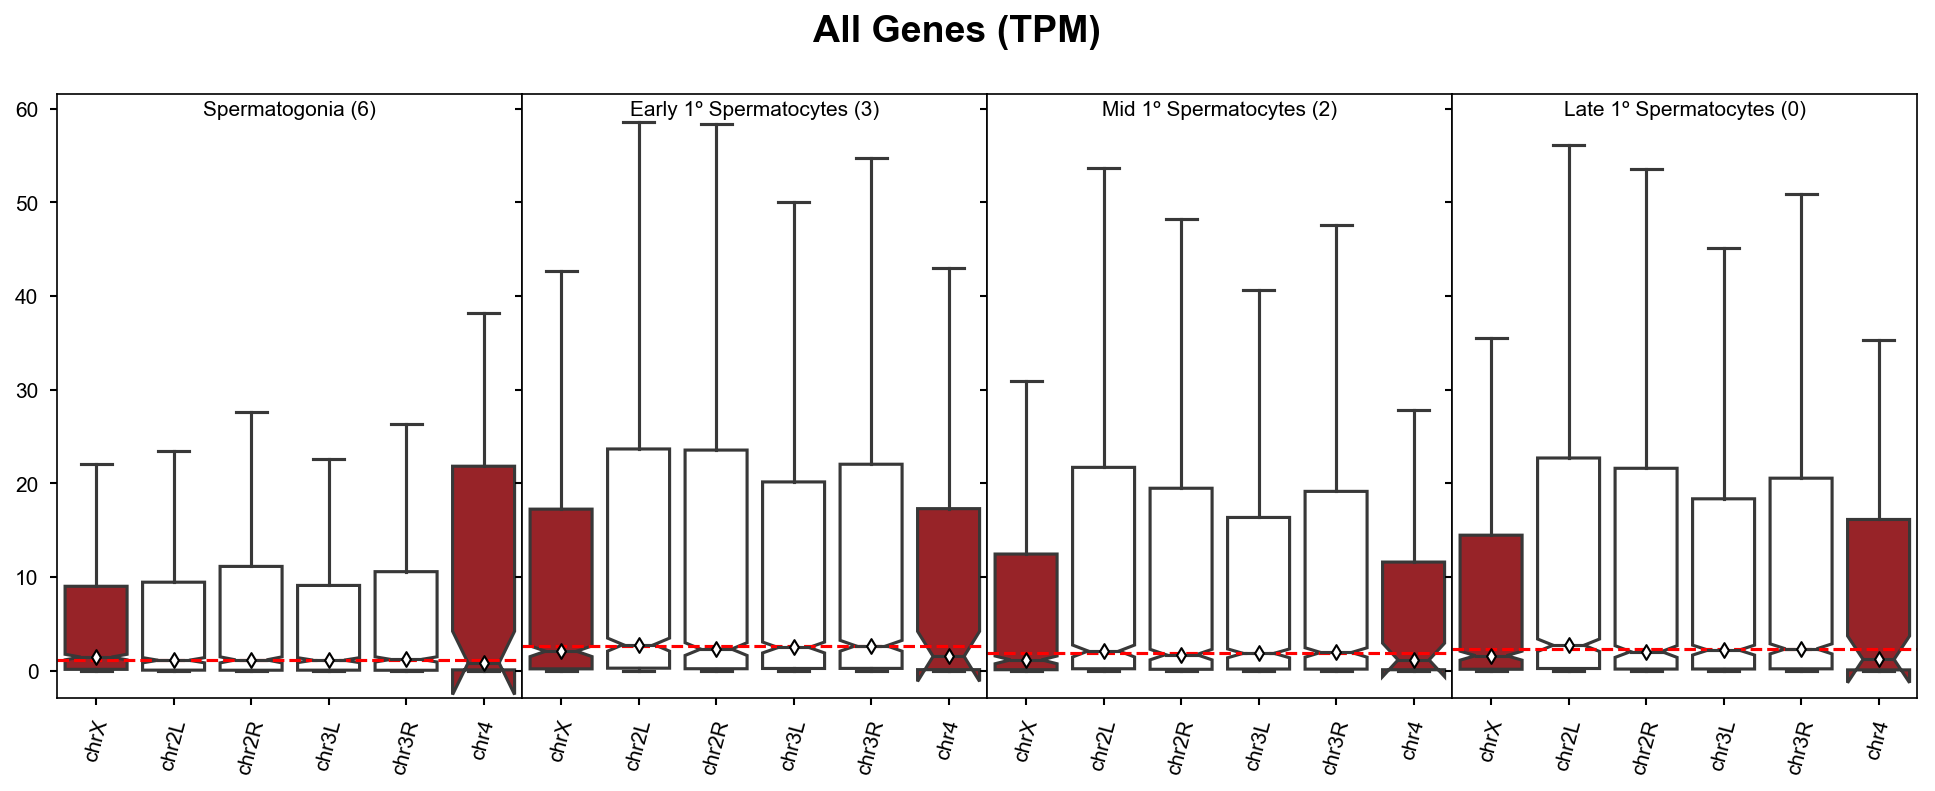

In [212]:
large_panel(tpm[~(tpm == 0).all(axis=1)], 'All Genes (TPM)')

,Late 1º Spermatocytes (0),Mid Cyst Cells (1),Mid 1º Spermatocytes (2),Early 1º Spermatocytes (3),Late Cyst Cells (4),Early Cyst Cells (5),Spermatogonia (6),Terminal Epithelium (7),Pigment Cells (8),Unknown (9),Unknown (10),Unknown (11)
chrom,,,,,,,,,,,,
chrX,0.697333,1.080704,0.607416,0.801839,1.110685,1.295563,1.256676,1.342351,1.199546,1.214855,1.020901,0.616298
chr2L,1.176436,1.070610,1.098743,1.073251,1.000772,0.975412,0.967204,0.966211,0.968450,1.022059,1.058136,1.086068
chr2R,0.886362,1.012039,0.900133,0.890292,1.038901,1.050120,1.000933,1.077302,1.092774,1.031917,0.946397,0.902171
chr3L,0.952863,0.962969,0.969385,0.955435,0.986541,1.001871,0.974945,0.962857,0.953759,0.970348,1.005733,0.978348
chr3R,1.010393,0.969245,1.017971,1.026007,0.961435,0.981261,1.043036,1.015154,0.999751,0.960693,1.009620,0.995084
chr4,0.526833,0.544281,0.605468,0.591403,0.923386,1.162872,0.722240,1.981681,2.025602,1.160143,0.749340,0.578573


cluster,Late 1º Spermatocytes (0),Mid Cyst Cells (1),Mid 1º Spermatocytes (2),Early 1º Spermatocytes (3),Late Cyst Cells (4),Early Cyst Cells (5),Spermatogonia (6),Terminal Epithelium (7),Pigment Cells (8),Unknown (9),Unknown (10),Unknown (11)
chrX,True,False,True,True,False,False,False,False,False,False,False,True


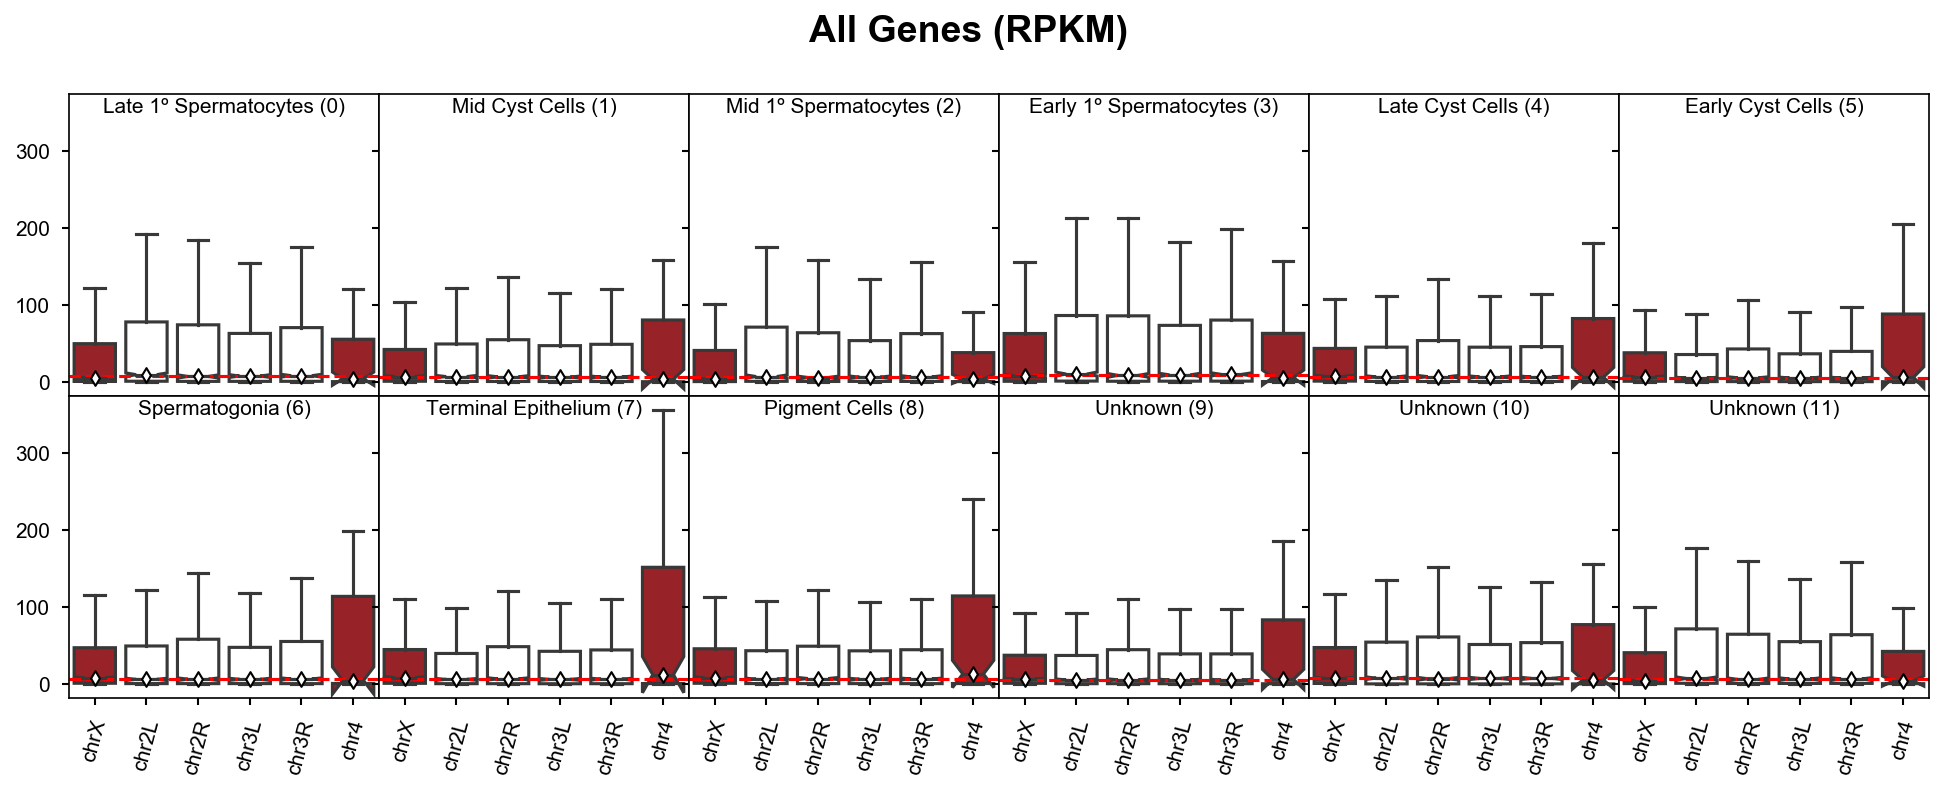

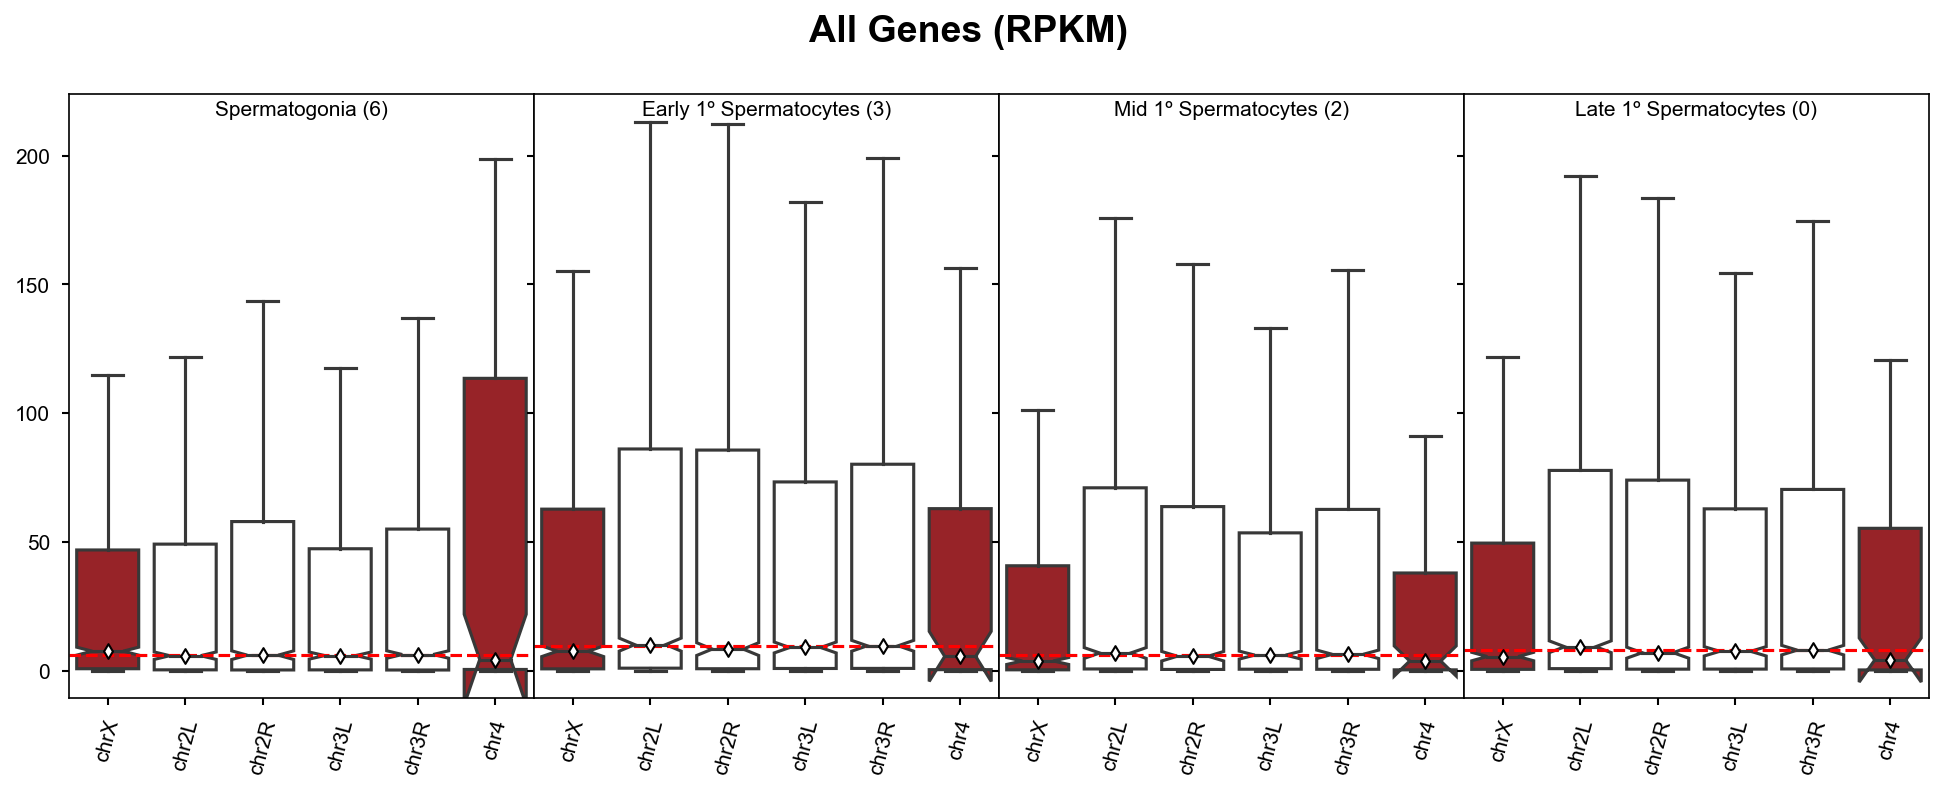

In [213]:
large_panel(rpkm[~(rpkm == 0).all(axis=1)], 'All Genes (RPKM)')

,Late 1º Spermatocytes (0),Mid Cyst Cells (1),Mid 1º Spermatocytes (2),Early 1º Spermatocytes (3),Late Cyst Cells (4),Early Cyst Cells (5),Spermatogonia (6),Terminal Epithelium (7),Pigment Cells (8),Unknown (9),Unknown (10),Unknown (11)
chrom,,,,,,,,,,,,
chrX,0.836640,1.339491,0.741251,0.903438,1.535835,1.797959,1.890893,1.902372,1.699163,1.608998,1.362250,0.746127
chr2L,1.155124,1.078889,1.165330,1.111274,1.068844,1.022856,1.073055,1.060467,1.027687,1.011095,1.103450,1.113338
chr2R,0.796934,0.942233,0.795859,0.788800,0.955608,0.939492,0.887960,0.998310,0.983901,0.889453,0.877004,0.799311
chr3L,1.037467,1.050066,1.039654,1.060178,1.020601,1.106031,0.969231,0.954630,1.036278,1.093464,1.019301,1.061923
chr3R,1.018069,0.925551,1.043047,1.035441,0.953857,0.957586,1.054956,0.988401,0.971893,0.977171,0.985194,1.000462
chr4,0.462013,0.859909,0.427098,0.539718,1.081989,0.868700,0.670213,1.259917,1.697076,1.115554,0.787642,0.477422


cluster,Late 1º Spermatocytes (0),Mid Cyst Cells (1),Mid 1º Spermatocytes (2),Early 1º Spermatocytes (3),Late Cyst Cells (4),Early Cyst Cells (5),Spermatogonia (6),Terminal Epithelium (7),Pigment Cells (8),Unknown (9),Unknown (10),Unknown (11)
chrX,False,False,True,False,False,False,False,False,False,False,False,True


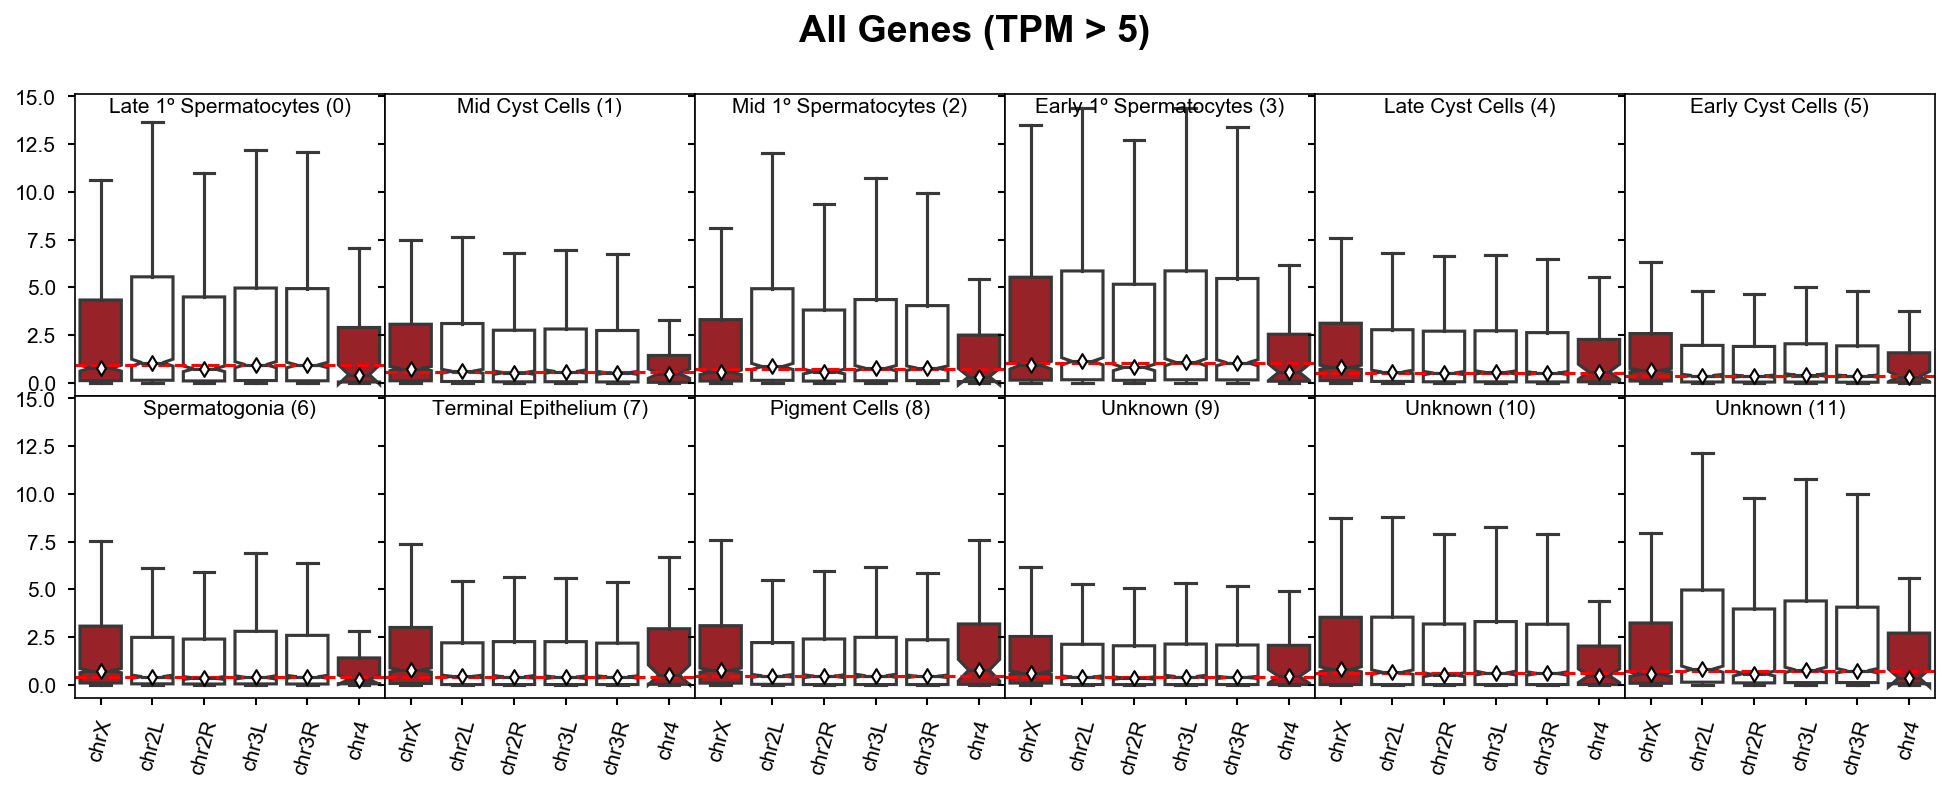

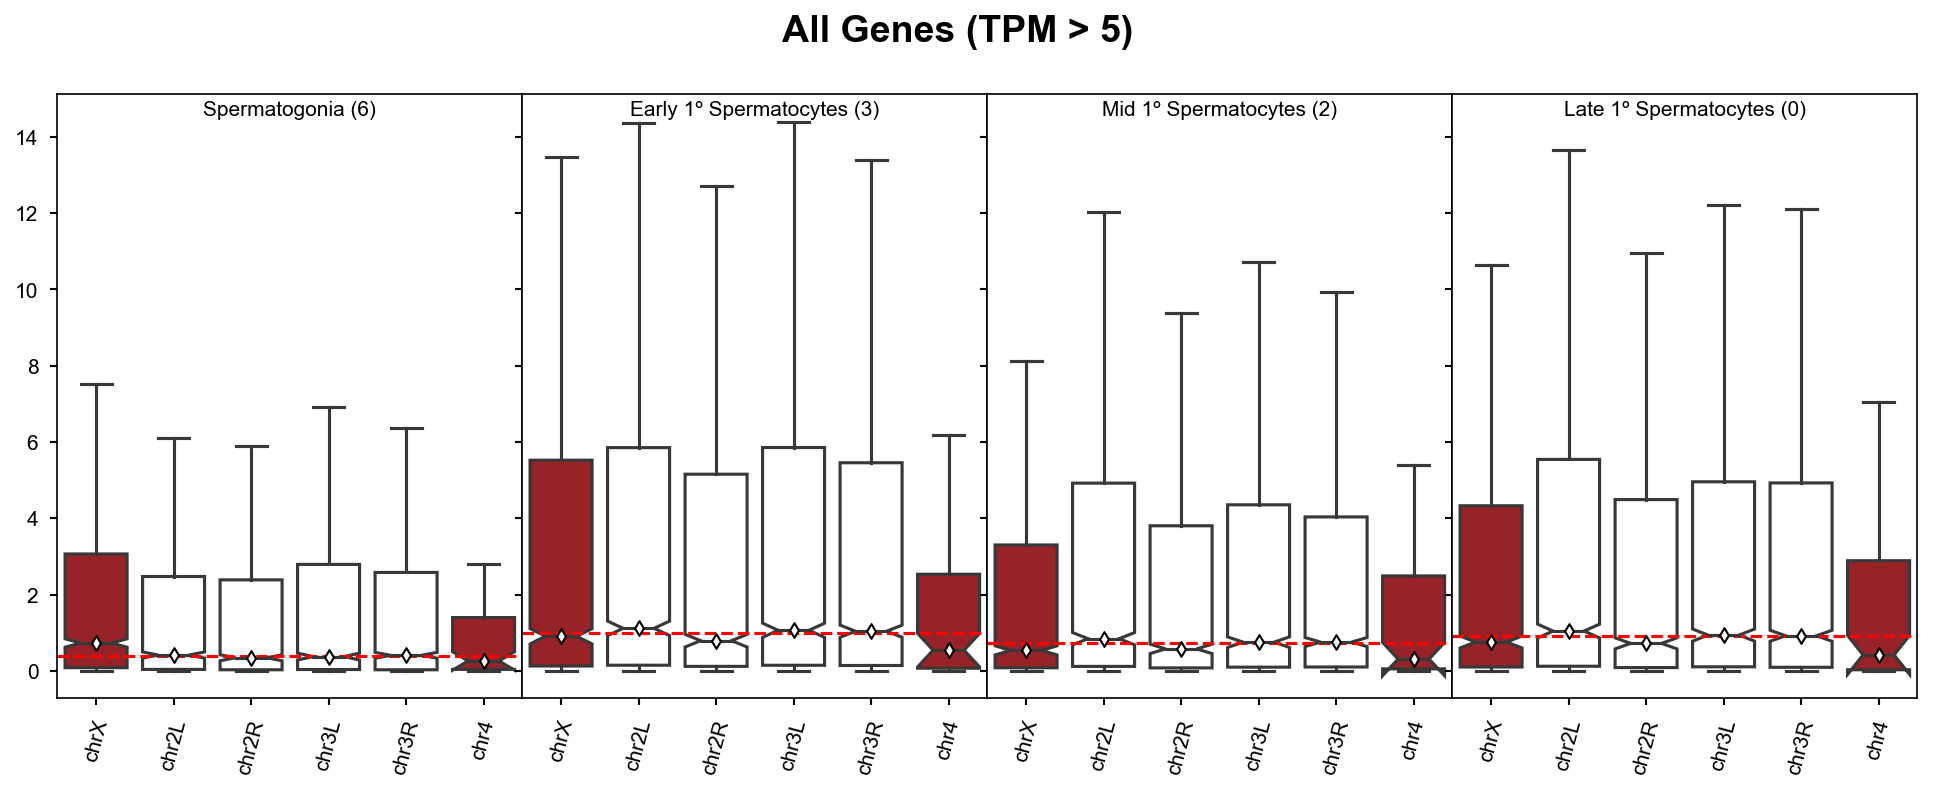

In [214]:
large_panel(tpm[~(tpm > 5).all(axis=1)], 'All Genes (TPM > 5)')

,Late 1º Spermatocytes (0),Mid Cyst Cells (1),Mid 1º Spermatocytes (2),Early 1º Spermatocytes (3),Late Cyst Cells (4),Early Cyst Cells (5),Spermatogonia (6),Terminal Epithelium (7),Pigment Cells (8),Unknown (9),Unknown (10),Unknown (11)
chrom,,,,,,,,,,,,
chrX,0.819515,1.448347,0.668614,0.876858,1.669750,2.139860,2.318555,2.645752,2.088638,2.069767,1.878431,0.653724
chr2L,1.164636,1.043550,1.140095,1.072240,1.045015,1.072032,1.047285,1.062617,1.044674,1.026927,1.225795,1.162376
chr2R,0.820698,0.955041,0.803444,0.846654,0.973174,0.970389,0.951671,0.984738,0.889519,0.992269,0.913725,0.816045
chr3L,0.972106,1.017282,1.026862,1.036178,1.010134,1.000000,1.048100,0.967958,1.009821,1.075962,0.985067,0.985213
chr3R,1.093921,0.995739,1.072838,1.049513,0.971824,1.020857,0.968765,1.021020,1.000725,0.910758,0.929699,1.100915
chr4,0.396345,1.238516,0.675902,0.460085,1.321705,1.328611,1.424596,1.916667,1.549645,0.903553,0.254462,0.338248


cluster,Late 1º Spermatocytes (0),Mid Cyst Cells (1),Mid 1º Spermatocytes (2),Early 1º Spermatocytes (3),Late Cyst Cells (4),Early Cyst Cells (5),Spermatogonia (6),Terminal Epithelium (7),Pigment Cells (8),Unknown (9),Unknown (10),Unknown (11)
chrX,False,False,True,False,False,False,False,False,False,False,False,True


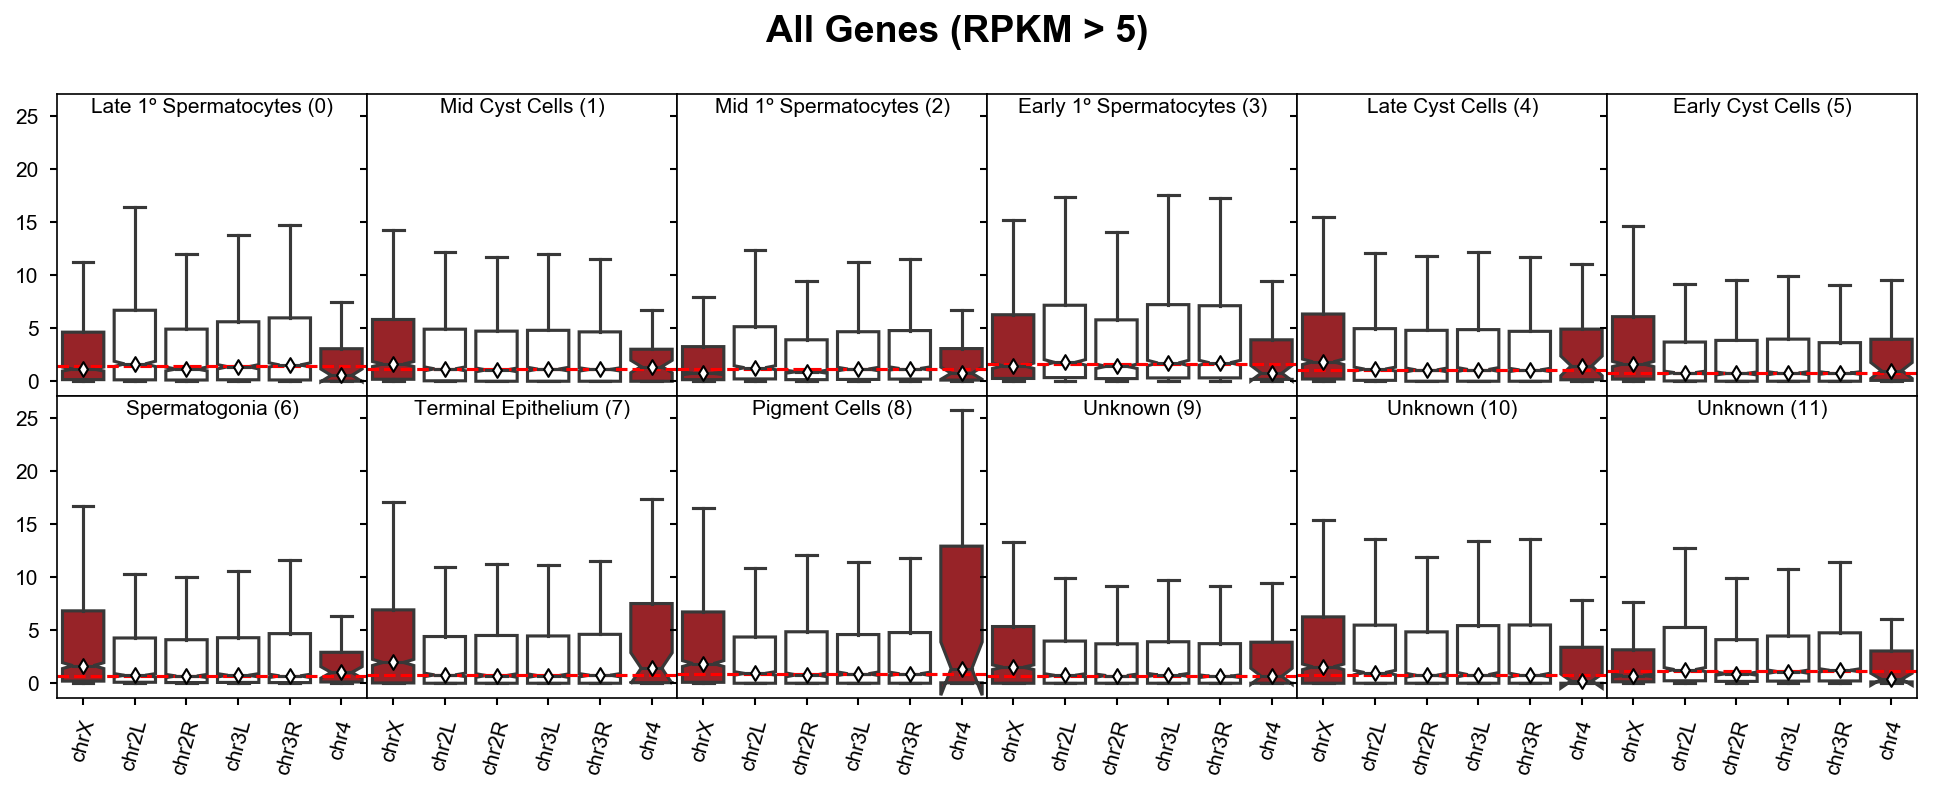

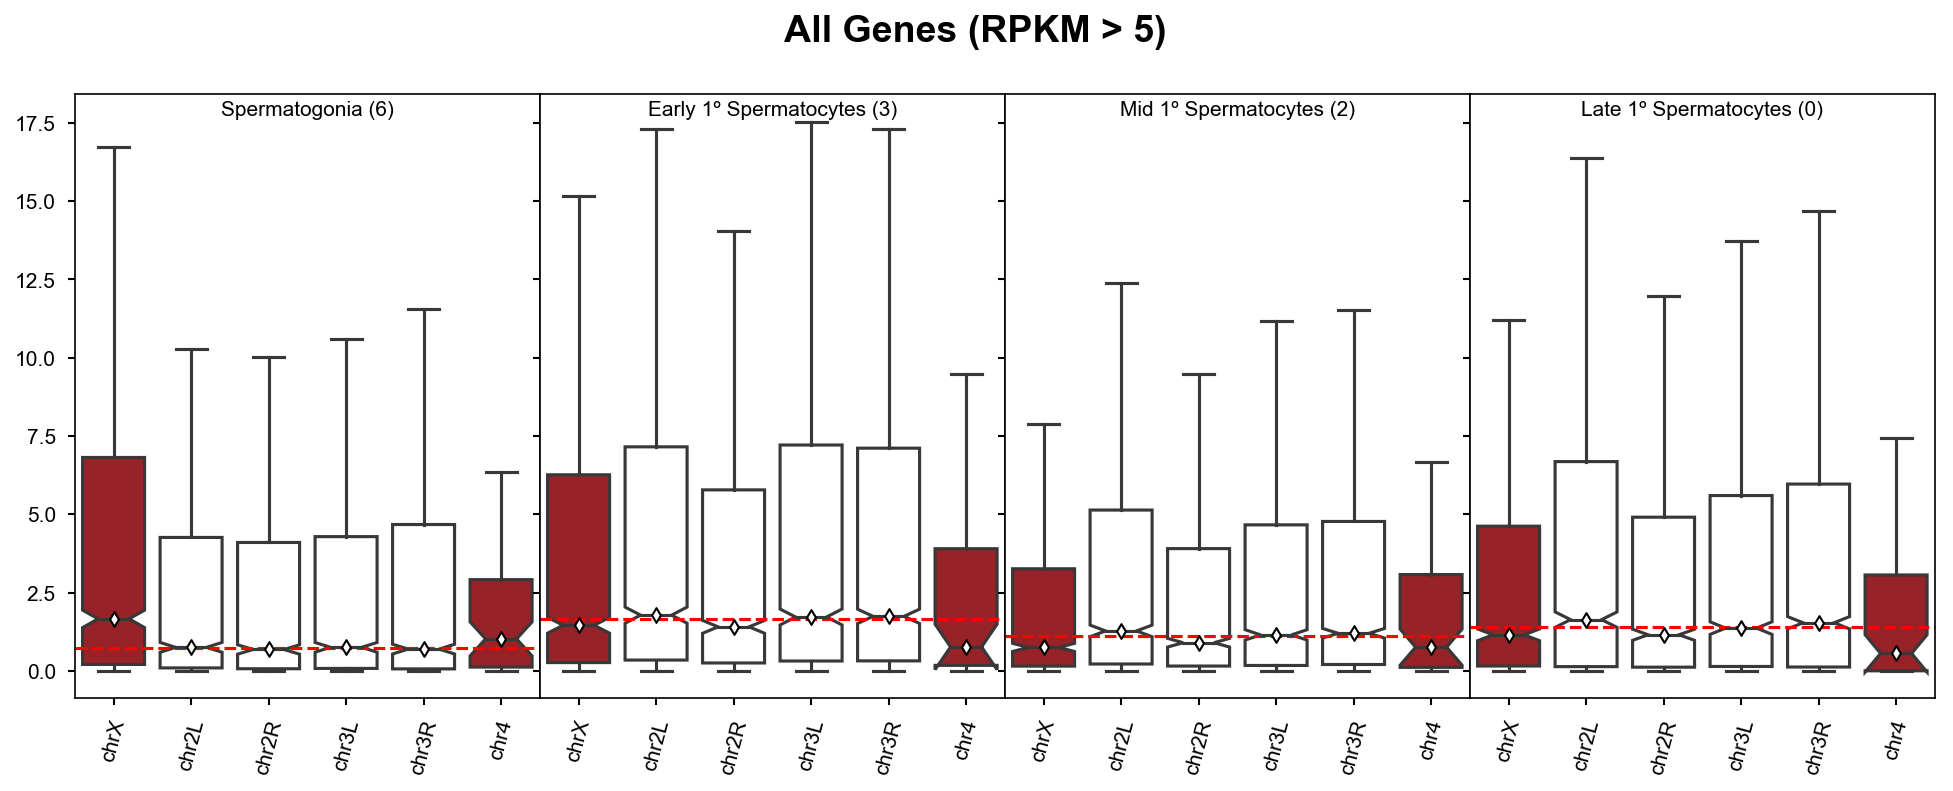

In [215]:
large_panel(rpkm[~(rpkm > 5).all(axis=1)], 'All Genes (RPKM > 5)')

In [216]:
coding = []
with open('../data/external/flybase_protein_coding_genes.txt') as fh:
    for row in fh.readlines():
        if row.startswith('#'):
            continue
        coding.append(row.strip())

,Late 1º Spermatocytes (0),Mid Cyst Cells (1),Mid 1º Spermatocytes (2),Early 1º Spermatocytes (3),Late Cyst Cells (4),Early Cyst Cells (5),Spermatogonia (6),Terminal Epithelium (7),Pigment Cells (8),Unknown (9),Unknown (10),Unknown (11)
chrom,,,,,,,,,,,,
chrX,0.790967,0.860213,0.664140,0.865008,0.894345,1.031728,0.966902,1.124167,1.061436,0.986341,0.881871,0.714453
chr2L,1.156399,1.067702,1.224896,1.207085,1.042010,1.007773,0.959704,1.015569,1.040027,1.075017,1.090355,1.275792
chr2R,1.021190,1.007193,1.027646,1.002561,0.968584,1.019515,1.059149,1.055536,1.043353,0.989648,1.002210,1.060107
chr3L,0.927075,0.980553,0.856674,0.932917,0.969890,0.951278,0.995845,0.986373,0.957383,0.981721,0.980783,0.859535
chr3R,0.901468,0.954242,0.922356,0.899850,0.993303,0.967678,0.992236,0.933692,0.948052,0.993977,0.934605,0.869742
chr4,0.474764,1.283592,0.338010,0.606490,1.846700,2.258114,1.825856,2.314462,2.227035,2.058711,1.258279,0.327930


cluster,Late 1º Spermatocytes (0),Mid Cyst Cells (1),Mid 1º Spermatocytes (2),Early 1º Spermatocytes (3),Late Cyst Cells (4),Early Cyst Cells (5),Spermatogonia (6),Terminal Epithelium (7),Pigment Cells (8),Unknown (9),Unknown (10),Unknown (11)
chrX,True,False,True,False,False,False,False,False,False,False,False,True


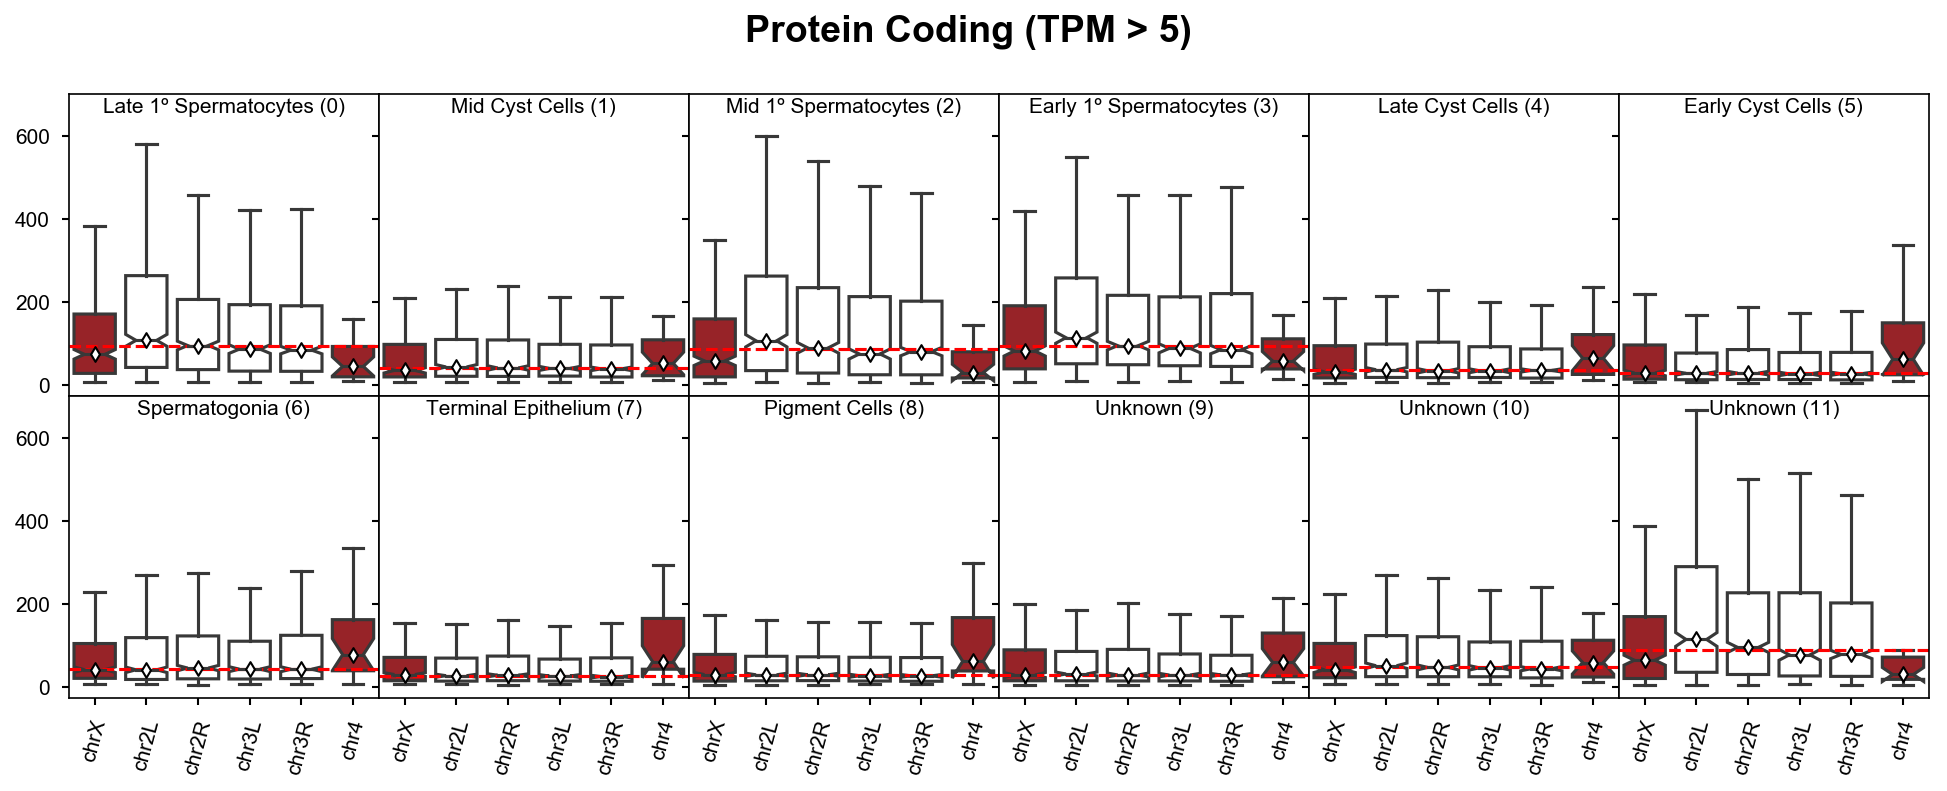

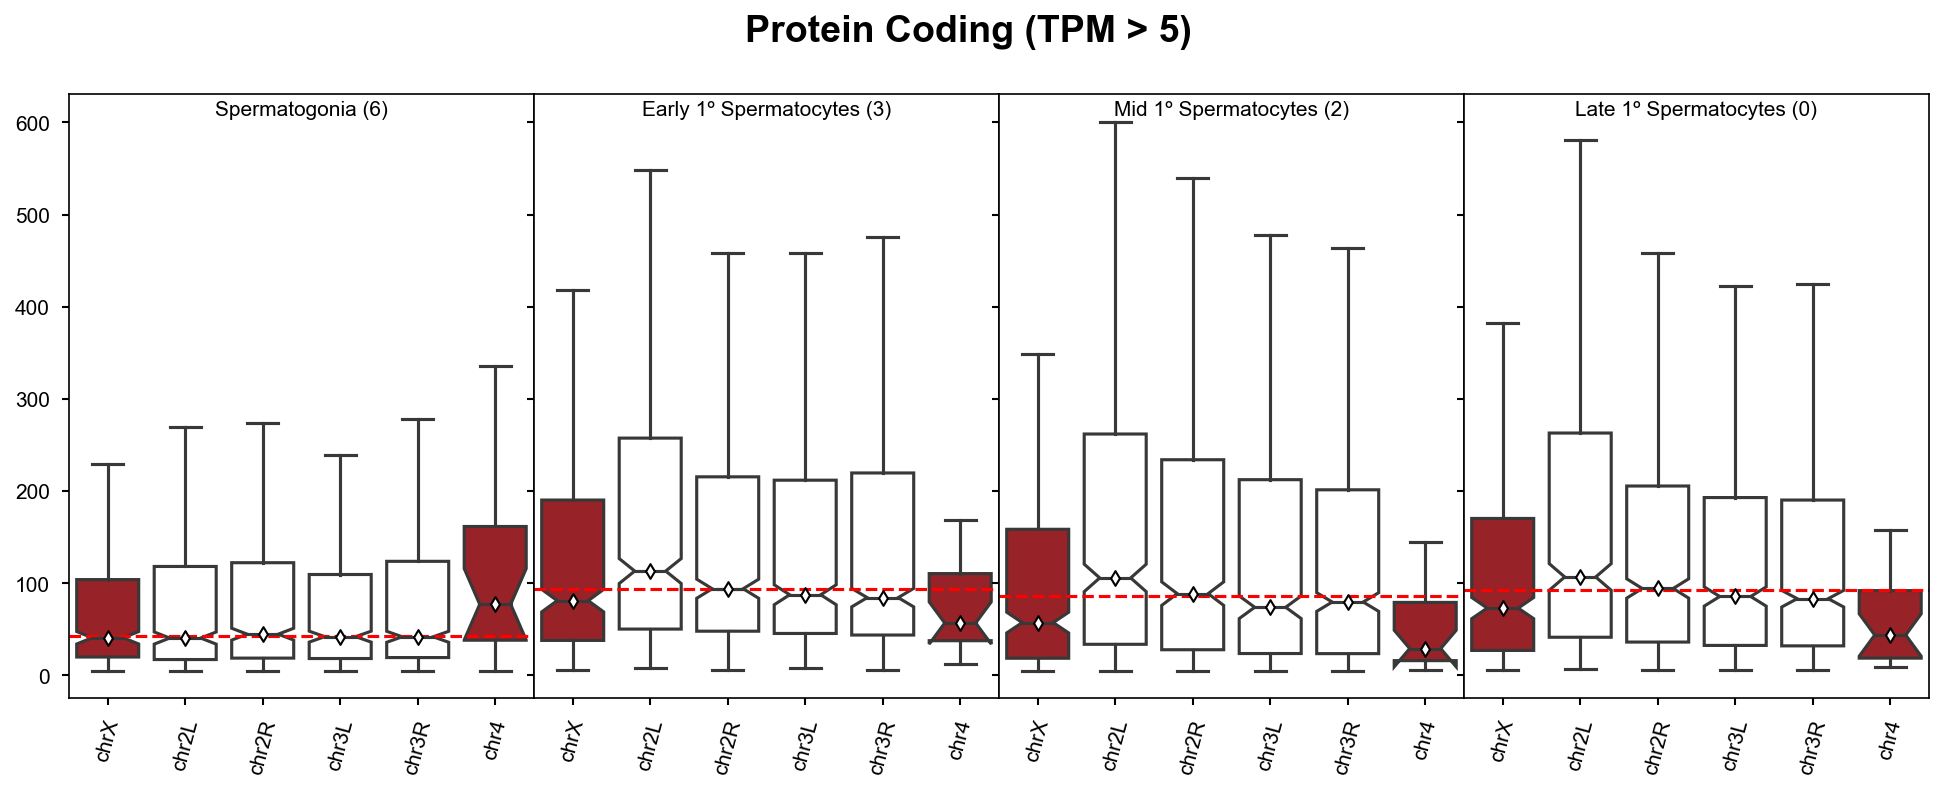

In [217]:
large_panel(tpm[(tpm > 5).all(axis=1) & tpm.index.isin(coding)], 'Protein Coding (TPM > 5)')

## Biomarker X chrom depletion

In [220]:
# get list of sig biomarkers for each germ cell cluster
biomarkers = nbconfig.seurat.get_biomarkers('res.0.6')

gonia = biomarkers.query('cluster == 6').index.tolist()
early = biomarkers.query('cluster == 4').index.tolist()
mid = biomarkers.query('cluster == 2').index.tolist()
late = biomarkers.query('cluster == 0').index.tolist()

# Build table for easy cross tabulation
bg = nbconfig.fbgn2chrom.reindex(snorm.index).dropna()
bg = bg.query('chrom != "chrM"')

bg.chrom.replace({
    'chr2L': 'Other', 
    'chr2R': 'Other', 
    'chr3L': 'Other', 
    'chr3R': 'Other', 
    'chr4': 'Other', 
    'chrY': 'Other',
}, inplace=True)

bg['gonia'] = False
bg['early'] = False
bg['mid'] = False
bg['late'] = False

bg.loc[bg.index.isin(gonia), 'gonia'] = True
bg.loc[bg.index.isin(early), 'early'] = True
bg.loc[bg.index.isin(mid), 'mid'] = True
bg.loc[bg.index.isin(late), 'late'] = True


def _ctab(c1, c2, title):
    """Quick crosstab and fisher's test."""
    _df = pd.crosstab(c1, c2)
    _df.columns.name = ''
    _, pval = fisher_exact(_df)
    if pval < 0.0001:
        pval = '<0.0001'
    else:
        pval = f'{pval:0.4f}'
        
    display(Markdown(f'### {title}'))
    display(_df)
    display(Markdown(f'**p-value:** {pval}'))

In [308]:
# Results
_ctab(bg.chrom, bg.gonia, 'Spermatogonia')
_ctab(bg.chrom, bg.early, 'Early 1º')
_ctab(bg.chrom, bg.mid, 'Mid 1º')
_ctab(bg.chrom, bg.late, 'Late 1º')

### Spermatogonia

,False,True
chrom,,
Other,11055,1200
chrX,2007,182


**p-value:** 0.0300

### Early 1º

,False,True
chrom,,
Other,11775,480
chrX,2081,108


**p-value:** 0.0297

### Mid 1º

,False,True
chrom,,
Other,10705,1550
chrX,1998,191


**p-value:** <0.0001

### Late 1º

,False,True
chrom,,
Other,11369,886
chrX,2090,99


**p-value:** <0.0001

## Build large data table.

In [23]:
writer = pd.ExcelWriter('../output/2018-06-29_biomarkers_and_cnts_tables.xlsx')

In [24]:
cell_format = writer.book.add_format({'valign': 'top'})
cell_format.set_text_wrap()

In [25]:
sheet = writer.book.add_worksheet('README')
writer.sheets['README'] = sheet

In [26]:
comment = """\
Genes with missing counts were not captured by the experiment. 
"""

In [27]:
sheet.set_column(0, 0, width=30, cell_format=cell_format)
sheet.set_column(1, 1, width=50, cell_format=cell_format)
sheet.set_row(0, height=50, cell_format=cell_format)
sheet.merge_range('A1:C1', comment);

In [28]:
col_desc = {
    'FBgn': 'FlyBase Gene ID',
    'gene_symbol': 'Gene Symbol', 
    'chrom': 'Chromosomal Arm',
    'p_val Cluster #': 'Seurat FindMarkers p-value', 
    'p_val_adj Cluster #': 'FDR Adjusted p-value', 
    'avg_logFC Cluster #': 'Average log Fold Change', 
    'Prop Cells in Cluster #': 'Proportion of Cells in cluster 0 with gene expressed.',
    'Prop Cells in Other Clusters Cluster #': 'Proportion of Cells in all other clusters with gene expressed.', 
    'Total Read Cnts Cluster #': 'Sum of raw read counts across cells',
    'Median Scaled Read Cnts Cluster #': 'Sum of raw read counts across cells scaled by median total read count across genes', 
    'TPM Read Cnts Cluster #': 'TPM normalized read count', 
    'RPKM Read Cnts Cluster #': 'RPKM normalized read count',
}

_desc = pd.Series(col_desc).to_frame()
_desc.index.name = 'Column Name'
_desc.columns = ['Column Description']
_desc.to_excel(writer, sheet_name='README', startrow=1)

In [29]:
# Gene annotation with symbols
gene_annot = pd.Series(nbconfig.fbgn2symbol)
gene_annot.name = 'gene_symbol'
gene_annot = gene_annot.to_frame().join(nbconfig.fbgn2chrom)

In [30]:
# Biomarkers
biomarker = nbconfig.seurat.get_biomarkers('res.0.6')
biomarker.drop('gene_symbol', axis=1, inplace=True)

In [31]:
dfs = []
for g, dd in biomarker.groupby('cluster'):
    raw = raw_data(nbconfig.seurat_dir, cluster=g)

    total_cnts = raw.sum(axis=1)
    total_cnts.name = 'Total Read Cnts'

    scaled_cnts = total_cnts / total_cnts.median()
    scaled_cnts.name = 'Median Scaled Read Cnts'

    gene_lens = pd.read_csv('../output/gene_ts_lengths.tsv', sep='\t', index_col='FBgn').gene_ts_length
    tpm_cnts = tpm(total_cnts.to_frame(), gene_lens).dropna().iloc[:, 0]
    tpm_cnts.name = 'TPM Read Cnts'

    rpkm_cnts = rpkm(total_cnts.to_frame(), gene_lens).dropna().iloc[:, 0]
    rpkm_cnts.name = 'RPKM Read Cnts'

    bio = dd.drop('cluster', axis=1)[['p_val', 'p_val_adj', 'avg_logFC', 'pct.1', 'pct.2']]
    bio.rename({'pct.1': f'Per Cells in Cluster {g}', 'pct.2': 'Per Cells in Other Clusters'}, axis=1, inplace=True)
    _dat = gene_annot.join(bio, how='left').join([total_cnts, scaled_cnts, tpm_cnts, rpkm_cnts], how='left')
    _dat.index.name = 'FBgn'
    _dat.set_index(['gene_symbol', 'chrom'], append=True, inplace=True)
    _dat.columns = [x + f' Cluster {g}' for x in _dat.columns]
    dfs.append(_dat)

In [32]:
df = pd.concat(dfs, axis=1, sort=True)

In [33]:
df.to_excel(writer, sheet_name='data_table')

In [34]:
writer.save()